# **V2** Thai Classical Music Generation – Baseline Sequence Modeling




## 0. Prerequisites & Setup

- Reuse normalized symbolic dataset from Stage 2  
- Pitch-only representation (octave stripped)  
- Rest token included as explicit `<REST>` symbol  
- Sequence = flattened token stream per song  

**Goal:**  
Train a baseline conditional LSTM language model on symbolic pitch sequences.

### 0.0 Libs

In [5]:
!pip install mido python-rtmidi
!pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [3]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2026-02-21 15:54:54--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2026-02-21 15:54:55--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.2’

thsarabunnew-webfon 100%[===================>]  96.00K   388KB/s    in 0.2s    

2026-02-21 15:54:57 (388 KB/s) - ‘

#### Colab-only: Clone repo & cd into it

In [6]:
# Uncomment on first Colab run:
# !git clone https://github.com/GetomG/Thai-Music-Thesis.git
# %cd Thai-Music-Thesis

# If already cloned:
# !cd Thai-Music-Thesis && git pull

Cloning into 'Thai-Music-Thesis'...


OSError: [Errno 5] Input/output error

In [7]:
# ============================================================
# Import Helper Utilities from thai_music_utils
# ============================================================

# 1. Notation Processing
from thai_music_utils.notation_utils import (
    flatten_song_notation,
    normalize_octave_markers,
    notation_to_sequence
)

# 2. Octave Inference (DP-based register guessing)
from thai_music_utils.octave_inference import (
    is_thai_note,
    get_fixed_octave,
    guess_octaves_with_constraints,
    add_octaves_respecting_labels
)

# 3. Preprocessing Utilities
from thai_music_utils.preprocessing import (
    flatten_song_data,
    remove_all_signs
)

# 4. EDA Helpers (Symbolic Analysis)
from thai_music_utils.eda_symbolic_normalization import (
    normalize_token,
    normalize_bar,
    flatten_song,
    THAI_NOTES,
    UP_MARK,
    LOW_MARK,
    REST_TOKEN
)

# 5. EDA Stats
from thai_music_utils.eda_stats import (
    extract_symbols,
    pitch_stats,
    stats_to_df
)

# 6. I/O Utilities
from thai_music_utils.io_utils import (
    save_json_bar_per_line
)

# 7. MIDI Rendering (Ranad-specific)
from thai_music_utils.midi_ranad import (
    generate_ranad_midi
)


In [8]:
#setting Thai fonts

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')
mpl.rcParams["axes.unicode_minus"] = False

In [9]:
import copy

### 0.1 Data Intake

In [10]:
import sys, os
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/drive/MyDrive/thai_music_data")
else:
    # Local: data lives next to the notebook
    DATA_ROOT = Path(os.path.abspath("")).resolve() / "thai_music_data"

print(f"Runtime: {'Colab' if IS_COLAB else 'Local'}")
print(f"DATA_ROOT: {DATA_ROOT}")

Runtime: Local
DATA_ROOT: /Users/thanakrit/Documents/Thai Music Thesis/thai_music_data


In [11]:
import json
from pathlib import Path
from collections import defaultdict

BASE = DATA_ROOT / "songs"

songs = []

for motif_dir in BASE.iterdir():
    if not motif_dir.is_dir():
        continue

    motif = motif_dir.name

    for song_dir in motif_dir.iterdir():
        json_dir = song_dir / "json"
        if not json_dir.exists():
            continue

        for json_file in json_dir.glob("*.json"):
            try:
                with open(json_file, "r", encoding="utf-8") as f:
                    data = json.load(f)

                songs.append({
                    "motif": motif,
                    "song": song_dir.name,
                    "path": str(json_file),
                    "data": data
                })

            except Exception as e:
                print(f"⚠️ Skipped {json_file}: {e}")

In [12]:
print(f"Total songs loaded: {len(songs)}")

by_motif = defaultdict(int)
for s in songs:
    by_motif[s["motif"]] += 1

for motif, n in by_motif.items():
    print(f"{motif}: {n} songs")

Total songs loaded: 44
เขมร: 7 songs
จีน: 4 songs
พม่า: 5 songs
ลาว: 18 songs
ไทยเดิม: 2 songs
แขก: 8 songs


#### **Filter only Khmer**

In [13]:
songs = [s for s in songs if s["motif"] == "เขมร"]

print("Total Khmer songs:", len(songs))

Total Khmer songs: 7


### *0.2* Symbolic Normalization & Sequence Construction

#### 1️⃣ Normalize + Flatten

Reuse the earlier symbolic normalization logic, but simplify it for sequence modeling.

**Goal:**
- Clean and standardize symbolic tokens
- Decide whether to keep or remove register (pitch-only vs pitch+register)
- Convert structured JSON (section → bar → token) into one linear sequence per song
- Prepare clean token streams ready for vocabulary building and LSTM training

Output:
Each song → one flat symbolic sequence (list of tokens)

#### `normalize_token` & `song_to_pitch_sequence`

These are the core functions for this notebook's tokenization:

- `normalize_token` — Strips octave markers, splits dashes into compressed `<REST_k>` tokens  
- `song_to_pitch_sequence` — Walks the full song JSON (sections → bars → tokens) and returns one flat token list

In [14]:
THAI_NOTES = set("ดรมฟซลท")
UP_MARK = "ํ"
LOW_MARK = "ฺ"

def normalize_token(token):
    """
    Convert token into pitch tokens + compressed rest tokens.

    Rest compression rule:
    - Any number of consecutive dashes is decomposed into
      chunks of <REST_4>, <REST_3>, <REST_2>, <REST_1>
    """

    if not isinstance(token, str):
        return ["<REST_1>"]

    token = token.strip()

    # ---- Pure rest token ----
    if set(token) == {"-"}:
        dash_count = len(token)
        rests = []

        while dash_count > 0:
            if dash_count >= 4:
                rests.append("<REST_4>")
                dash_count -= 4
            elif dash_count >= 3:
                rests.append("<REST_3>")
                dash_count -= 3
            elif dash_count >= 2:
                rests.append("<REST_2>")
                dash_count -= 2
            else:
                rests.append("<REST_1>")
                dash_count -= 1

        return rests

    # ---- Mixed pitch token ----
    out = []
    i = 0

    while i < len(token):
        ch = token[i]

        if ch == "-":
            # count consecutive dashes
            dash_count = 0
            while i < len(token) and token[i] == "-":
                dash_count += 1
                i += 1

            while dash_count > 0:
                if dash_count >= 4:
                    out.append("<REST_4>")
                    dash_count -= 4
                elif dash_count >= 3:
                    out.append("<REST_3>")
                    dash_count -= 3
                elif dash_count >= 2:
                    out.append("<REST_2>")
                    dash_count -= 2
                else:
                    out.append("<REST_1>")
                    dash_count -= 1

        elif ch in THAI_NOTES:
            out.append(ch)
            i += 1

            # skip octave mark
            if i < len(token) and token[i] in {UP_MARK, LOW_MARK}:
                i += 1

        else:
            i += 1

    return out if out else ["<REST_1>"]

def song_to_pitch_sequence(song_json):
    """
    Convert full song JSON into one flat pitch sequence.
    Handles:
    - normal string tokens
    - dict blocks like {"นำ": [...]}, {"ตาม": [...]}
    - nested lists
    """

    sequence = []

    def process_token(tok):
        # Case 1: string token
        if isinstance(tok, str):
            sequence.extend(normalize_token(tok))

        # Case 2: dict (นำ / ตาม block)
        elif isinstance(tok, dict):
            for key in tok:
                for inner_tok in tok[key]:
                    process_token(inner_tok)

        # Case 3: list (nested structure)
        elif isinstance(tok, list):
            for inner_tok in tok:
                process_token(inner_tok)

    for section in song_json.get("sections", []):
        for bar in section.get("bars", []):
            for tok in bar:
                process_token(tok)

    return sequence

#### Apply to songs

In [15]:
#Apply to songs
for s in songs:
    s["pitch_sequence"] = song_to_pitch_sequence(s["data"])

print(len(songs[2]["pitch_sequence"]))
print(songs[2]["pitch_sequence"][:80])

1007
['<REST_4>', '<REST_3>', 'ฟ', '<REST_1>', 'ฟ', 'ฟ', 'ฟ', '<REST_1>', 'ฟ', '<REST_1>', 'ฟ', '<REST_1>', 'ล', 'ด', 'ร', '<REST_1>', 'ฟ', '<REST_1>', 'ซ', 'ล', 'ซ', 'ด', 'ล', '<REST_1>', 'ซ', '<REST_1>', 'ฟ', '<REST_2>', 'ฟ', 'ซ', 'ล', '<REST_1>', 'ด', '<REST_1>', 'ร', '<REST_1>', 'ซ', 'ฟ', 'ร', '<REST_1>', 'ด', '<REST_1>', 'ล', '<REST_3>', 'ซ', '<REST_3>', 'ล', '<REST_2>', 'ร', 'ด', 'ล', 'ด', '<REST_1>', 'ร', '<REST_4>', '<REST_4>', '<REST_3>', 'ฟ', '<REST_3>', 'ซ', '<REST_2>', 'ฟ', 'ล', '<REST_1>', 'ซ', 'ฟ', 'ร', '<REST_4>', '<REST_4>', '<REST_3>', 'ฟ', '<REST_3>', 'ร', 'ด', 'ร', 'ฟ', 'ด', '<REST_4>', 'ซ', 'ล']


In [16]:
from collections import defaultdict

note_count_by_motif = defaultdict(int)
song_count_by_motif = defaultdict(int)

for s in songs:
    motif = s["motif"]
    note_count_by_motif[motif] += len(s["pitch_sequence"])
    song_count_by_motif[motif] += 1

print("=== Note Count per Motif ===\n")

for motif in sorted(note_count_by_motif.keys()):
    total_notes = note_count_by_motif[motif]
    total_songs = song_count_by_motif[motif]
    avg_len = total_notes / total_songs

    print(f"{motif}:")
    print(f"  Total notes (including rests): {total_notes}")
    print(f"  Songs: {total_songs}")
    print(f"  Avg notes per song: {avg_len:.2f}")
    print()

=== Note Count per Motif ===

เขมร:
  Total notes (including rests): 5936
  Songs: 7
  Avg notes per song: 848.00



### *0.3* Per-Song Token Breakdown

Quick audit of each song's token composition after normalization — pitch tokens vs rest tokens, total length, and coverage.  
Reusable for any motif: just re-run this cell after filtering `songs`.

In [83]:
import re

REST_PAT = re.compile(r"^<REST_\d+>$")

rows = []
for s in songs:
    seq = s["pitch_sequence"]
    pitch_toks  = [t for t in seq if not REST_PAT.match(t)]
    rest_toks   = [t for t in seq if REST_PAT.match(t)]
    unique_toks = set(seq)

    # count bars from the original JSON
    n_bars = sum(len(sec.get("bars", [])) for sec in s["data"].get("sections", []))

    rows.append({
        "song"          : s["song"],
        "total_tokens"  : len(seq),
        "pitch_tokens"  : len(pitch_toks),
        "rest_tokens"   : len(rest_toks),
        "rest_%"        : f"{100*len(rest_toks)/len(seq):.1f}%" if seq else "—",
        "unique_tokens" : len(unique_toks),
        "bars"          : n_bars,
        "tok/bar"       : f"{len(seq)/n_bars:.1f}" if n_bars else "—",
    })

rows.sort(key=lambda r: r["total_tokens"], reverse=True)

# ── pretty-print table ───────────────────────────────────────────────────────
HDR = f"{'Song':<32} {'Total':>7} {'Pitch':>6} {'Rest':>6} {'Rest%':>6} {'Uniq':>5} {'Bars':>5} {'Tok/Bar':>8}"
print(HDR)
print("─" * len(HDR))
for r in rows:
    print(f"{r['song']:<32} {r['total_tokens']:>7} {r['pitch_tokens']:>6} "
          f"{r['rest_tokens']:>6} {r['rest_%']:>6} {r['unique_tokens']:>5} "
          f"{r['bars']:>5} {r['tok/bar']:>8}")

print("─" * len(HDR))
total_all    = sum(r["total_tokens"] for r in rows)
pitch_all    = sum(r["pitch_tokens"] for r in rows)
rest_all     = sum(r["rest_tokens"]  for r in rows)
corpus_vocab = set(t for s in songs for t in s["pitch_sequence"])

print(f"{'CORPUS TOTAL':<32} {total_all:>7} {pitch_all:>6} {rest_all:>6} "
      f"{f'{100*rest_all/total_all:.1f}%':>6}")
print(f"\nCorpus vocab size  : {len(corpus_vocab)} unique tokens")
print(f"Songs in corpus    : {len(rows)}")

Song                               Total  Pitch   Rest  Rest%  Uniq  Bars  Tok/Bar
──────────────────────────────────────────────────────────────────────────────────
เขมรโพธิสัตว์                       1679   1246    433  25.8%    11    70     24.0
เขมรพวง                             1007    730    277  27.5%    11    48     21.0
เขมรลออองค์                          838    598    240  28.6%    11    52     16.1
เขมรชนบท                             759    581    178  23.5%    11    28     27.1
เขมรปากท่อ                           717    505    212  29.6%    11    35     20.5
เขมรพายเรือ                          610    475    135  22.1%    11    42     14.5
เขมรไทรโยค                           326    228     98  30.1%    10    17     19.2
──────────────────────────────────────────────────────────────────────────────────
CORPUS TOTAL                        5936   4363   1573  26.5%

Corpus vocab size  : 11 unique tokens
Songs in corpus    : 7


#### 2️⃣ Build Vocabulary (Token → Integer Mapping)

Neural networks cannot process symbolic tokens directly.  
We must convert each pitch token into a numeric ID.

Steps:
- Collect all unique tokens from all songs
- Assign each token a unique integer
- Build two mappings:
  - `token_to_id`
  - `id_to_token`

This defines:
- The model vocabulary
- The input/output dimension for the LSTM

In [17]:
from collections import Counter

# Collect all tokens across songs
all_tokens = []

for s in songs:
    all_tokens.extend(s["pitch_sequence"])

# Unique vocabulary
vocab = sorted(set(all_tokens))

# Create mappings
token_to_id = {tok: i for i, tok in enumerate(vocab)}
id_to_token = {i: tok for tok, i in token_to_id.items()}

vocab_size = len(vocab)

print("Vocabulary:", vocab)
print("Vocab size:", vocab_size)

Vocabulary: ['<REST_1>', '<REST_2>', '<REST_3>', '<REST_4>', 'ซ', 'ด', 'ท', 'ฟ', 'ม', 'ร', 'ล']
Vocab size: 11


#### 3️⃣ Convert Songs to Integer Sequences

Neural networks cannot process symbolic tokens directly.  
We must convert each pitch token into a numeric ID.

Steps:
- Take each song’s `pitch_sequence`
- Replace each token with its corresponding integer ID using `token_to_id`
- Store the new numeric sequence (e.g., `id_sequence`) inside each song

This produces:
- One integer sequence per song  
- Shape per song: `(sequence_length,)`
- Vocabulary size = `vocab_size`

These integer sequences will be used to:
- Create training samples (input → next token prediction)
- Feed into the LSTM model
- Compute loss over predicted next-token probabilities

In [18]:
# 3️⃣ Convert Songs to Integer Sequences

for s in songs:
    s["id_sequence"] = [
        token_to_id[token]
        for token in s["pitch_sequence"]
        if token in token_to_id
    ]

# sanity check
print("Example song length:", len(songs[2]["id_sequence"]))
print("First 30 token IDs:", songs[2]["id_sequence"][:30])

Example song length: 1007
First 30 token IDs: [3, 2, 7, 0, 7, 7, 7, 0, 7, 0, 7, 0, 10, 5, 9, 0, 7, 0, 4, 10, 4, 5, 10, 0, 4, 0, 7, 1, 7, 4]


#### 4️⃣ Prepare Training Sequences (LSTM Input Construction)

The LSTM does not see full songs at once.

Instead, we train it using sliding windows:

Given a sequence:
ด ร ม ซ ด ร ด ...

We create training samples like:

```
Input (length = seq_len) → Target
[ด ร ม ซ] → ด
[ร ม ซ ด] → ร
[ม ซ ด ร] → ด
```

This teaches the model:
"Given the previous N notes, predict the next note."

Steps:
- Choose a sequence length (e.g., 16)
- Slide window across every song
- Convert token IDs into (X, y) pairs
- X shape: (num_samples, seq_len)
- y shape: (num_samples,)

In [19]:
for s in songs:
    s["id_sequence"] = [
        token_to_id[token]
        for token in s["pitch_sequence"]
    ]

In [20]:
import numpy as np

SEQ_LEN = 16  # number of previous notes to condition on

X = []
y = []

for s in songs:
    ids = s["id_sequence"]

    if len(ids) <= SEQ_LEN:
        continue

    for i in range(len(ids) - SEQ_LEN):
        X.append(ids[i:i+SEQ_LEN])
        y.append(ids[i+SEQ_LEN])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5824, 16)
y shape: (5824,)


## 1️⃣ LSTM Model Definition

We now define a baseline LSTM language model.

Goal:
- Input: sequence of 16 token IDs
- Output: probability distribution over next token

Architecture:
- Embedding layer (token → dense vector)
- LSTM layer
- Linear output layer
- Softmax handled by CrossEntropyLoss

This is a standard neural language model setup.

In [21]:
# ============================================================
# 0. PREREQUISITES
# ============================================================

import numpy as np
import random
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [23]:
import torch
import torch.nn as nn

# ============================================================
# LSTM Language Model (Improved Version)
# - 2-layer stacked LSTM
# - Dropout between layers
# - Predict next token from last hidden state
# ============================================================

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=2, dropout=0.25):
        super().__init__()

        # 1️⃣ Embedding Layer
        # Converts token IDs → dense vectors
        # Shape: (batch, seq_len) → (batch, seq_len, embed_dim)
        # --------------------------------------------------------
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )

        # 2️⃣ Stacked LSTM
        # num_layers=2 → hierarchical pattern modeling
        # dropout applied BETWEEN LSTM layers
        # --------------------------------------------------------
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # 3️⃣ Final Linear Layer
        # Maps final hidden state → vocabulary logits
        # Shape: (batch, hidden_dim) → (batch, vocab_size)
        # --------------------------------------------------------
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len)
        """

        # Step 1: Convert tokens to embeddings
        x = self.embedding(x)

        # Step 2: Pass through stacked LSTM
        # output shape: (batch, seq_len, hidden_dim)
        output, _ = self.lstm(x)

        # Step 3: Take last timestep only
        last_hidden = output[:, -1, :]

        # Step 4: Project to vocab size
        logits = self.fc(last_hidden)

        return logits


# Instantiate model
# ------------------------------------------------------------
model = LSTMLanguageModel(vocab_size).to(device)

print(model)

LSTMLanguageModel(
  (embedding): Embedding(11, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)


### 1️⃣ Training Setup

Now we train the LSTM as a next-token predictor.

Task:
Given 16 previous tokens → predict the next token.

We define:

• Loss: CrossEntropyLoss  
  - Standard for multi-class classification  
  - Compares predicted distribution vs true next-token  

• Optimizer: Adam  
  - Stable for sequence models  
  - Good default for LSTM  

• Training loop:
  1. Forward pass
  2. Compute loss
  3. Backpropagation
  4. Update weights
  5. Repeat for multiple epochs

Goal:
Minimize next-token prediction loss.

In [ ]:
from tqdm import tqdm

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# Training config
epochs = 30
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_samples = X_tensor.shape[0]


In [ ]:
import math  # put this once at top of notebook
for epoch in range(epochs):

    model.train()
    total_loss = 0.0

    progress_bar = tqdm(
        range(0, num_samples, batch_size),
        desc=f"Epoch {epoch+1}/{epochs}"
    )

    for i in progress_bar:

        X_batch = X_tensor[i:i+batch_size]
        y_batch = y_tensor[i:i+batch_size]

        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / (num_samples // batch_size)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    perplexity = math.exp(avg_loss)
    print(f"Epoch {epoch+1} Perplexity: {perplexity:.4f}")

Epoch 1/30: 100%|██████████| 91/91 [00:05<00:00, 16.89it/s, loss=0.635]


Epoch 1 Average Loss: 0.5374
Epoch 1 Perplexity: 1.7115


Epoch 2/30: 100%|██████████| 91/91 [00:07<00:00, 12.70it/s, loss=0.574]


Epoch 2 Average Loss: 0.4845
Epoch 2 Perplexity: 1.6233


Epoch 3/30: 100%|██████████| 91/91 [00:05<00:00, 17.12it/s, loss=0.578]


Epoch 3 Average Loss: 0.4638
Epoch 3 Perplexity: 1.5901


Epoch 4/30: 100%|██████████| 91/91 [00:05<00:00, 15.59it/s, loss=0.521]


Epoch 4 Average Loss: 0.4309
Epoch 4 Perplexity: 1.5387


Epoch 5/30: 100%|██████████| 91/91 [00:06<00:00, 14.28it/s, loss=0.482]


Epoch 5 Average Loss: 0.3998
Epoch 5 Perplexity: 1.4915


Epoch 6/30: 100%|██████████| 91/91 [00:05<00:00, 17.14it/s, loss=0.488]


Epoch 6 Average Loss: 0.3833
Epoch 6 Perplexity: 1.4672


Epoch 7/30: 100%|██████████| 91/91 [00:07<00:00, 12.91it/s, loss=0.388]


Epoch 7 Average Loss: 0.3488
Epoch 7 Perplexity: 1.4174


Epoch 8/30: 100%|██████████| 91/91 [00:05<00:00, 18.02it/s, loss=0.401]


Epoch 8 Average Loss: 0.3263
Epoch 8 Perplexity: 1.3859


Epoch 9/30: 100%|██████████| 91/91 [00:05<00:00, 17.19it/s, loss=0.383]


Epoch 9 Average Loss: 0.3121
Epoch 9 Perplexity: 1.3663


Epoch 10/30: 100%|██████████| 91/91 [00:06<00:00, 13.01it/s, loss=0.375]


Epoch 10 Average Loss: 0.2934
Epoch 10 Perplexity: 1.3410


Epoch 11/30: 100%|██████████| 91/91 [00:05<00:00, 17.28it/s, loss=0.24]


Epoch 11 Average Loss: 0.2834
Epoch 11 Perplexity: 1.3276


Epoch 12/30: 100%|██████████| 91/91 [00:06<00:00, 13.75it/s, loss=0.279]


Epoch 12 Average Loss: 0.2658
Epoch 12 Perplexity: 1.3045


Epoch 13/30: 100%|██████████| 91/91 [00:05<00:00, 16.14it/s, loss=0.186]


Epoch 13 Average Loss: 0.2423
Epoch 13 Perplexity: 1.2742


Epoch 14/30: 100%|██████████| 91/91 [00:05<00:00, 17.38it/s, loss=0.194]


Epoch 14 Average Loss: 0.2215
Epoch 14 Perplexity: 1.2479


Epoch 15/30: 100%|██████████| 91/91 [00:07<00:00, 12.93it/s, loss=0.203]


Epoch 15 Average Loss: 0.2191
Epoch 15 Perplexity: 1.2449


Epoch 16/30: 100%|██████████| 91/91 [00:05<00:00, 15.23it/s, loss=0.198]


Epoch 16 Average Loss: 0.2120
Epoch 16 Perplexity: 1.2361


Epoch 17/30: 100%|██████████| 91/91 [00:06<00:00, 13.17it/s, loss=0.228]


Epoch 17 Average Loss: 0.1973
Epoch 17 Perplexity: 1.2181


Epoch 18/30: 100%|██████████| 91/91 [00:05<00:00, 16.53it/s, loss=0.17]


Epoch 18 Average Loss: 0.1869
Epoch 18 Perplexity: 1.2055


Epoch 19/30: 100%|██████████| 91/91 [00:05<00:00, 17.31it/s, loss=0.186]


Epoch 19 Average Loss: 0.1765
Epoch 19 Perplexity: 1.1931


Epoch 20/30: 100%|██████████| 91/91 [00:07<00:00, 12.87it/s, loss=0.171]


Epoch 20 Average Loss: 0.1690
Epoch 20 Perplexity: 1.1841


Epoch 21/30: 100%|██████████| 91/91 [00:05<00:00, 17.16it/s, loss=0.0998]


Epoch 21 Average Loss: 0.1531
Epoch 21 Perplexity: 1.1654


Epoch 22/30: 100%|██████████| 91/91 [00:06<00:00, 13.45it/s, loss=0.182]


Epoch 22 Average Loss: 0.1517
Epoch 22 Perplexity: 1.1638


Epoch 23/30: 100%|██████████| 91/91 [00:05<00:00, 16.28it/s, loss=0.099]


Epoch 23 Average Loss: 0.1426
Epoch 23 Perplexity: 1.1533


Epoch 24/30: 100%|██████████| 91/91 [00:05<00:00, 17.17it/s, loss=0.101]


Epoch 24 Average Loss: 0.1306
Epoch 24 Perplexity: 1.1396


Epoch 25/30: 100%|██████████| 91/91 [00:07<00:00, 12.83it/s, loss=0.0746]


Epoch 25 Average Loss: 0.1335
Epoch 25 Perplexity: 1.1428


Epoch 26/30: 100%|██████████| 91/91 [00:05<00:00, 17.22it/s, loss=0.111]


Epoch 26 Average Loss: 0.1296
Epoch 26 Perplexity: 1.1384


Epoch 27/30: 100%|██████████| 91/91 [00:06<00:00, 14.00it/s, loss=0.143]


Epoch 27 Average Loss: 0.1267
Epoch 27 Perplexity: 1.1351


Epoch 28/30: 100%|██████████| 91/91 [00:05<00:00, 15.75it/s, loss=0.117]


Epoch 28 Average Loss: 0.1193
Epoch 28 Perplexity: 1.1267


Epoch 29/30: 100%|██████████| 91/91 [00:05<00:00, 17.33it/s, loss=0.0982]


Epoch 29 Average Loss: 0.1146
Epoch 29 Perplexity: 1.1214


Epoch 30/30: 100%|██████████| 91/91 [00:07<00:00, 12.92it/s, loss=0.0955]

Epoch 30 Average Loss: 0.1097
Epoch 30 Perplexity: 1.1159


In [ ]:
WEIGHTS_DIR = DATA_ROOT / "weights"
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

print("Weights directory:", WEIGHTS_DIR)

Weights directory: /content/drive/MyDrive/thai_music_data/weights


In [ ]:
import torch

torch.save(model.state_dict(), WEIGHTS_DIR / "lstm_pitch_only_khmer_35.pth")
print("Model saved.")

Model saved.


## 2️⃣ Generation (Sampling)

Now we use the trained LSTM to generate new symbolic pitch sequences.

The model works as a next-token predictor:
- Input: 16-token context window
- Output: probability distribution over next token

Generation procedure:
1. Start with a seed sequence
2. Predict next token
3. Append prediction
4. Slide window forward
5. Repeat

We use **temperature sampling**:
- Low temperature (<1.0) → safer, repetitive
- High temperature (>1.0) → more creative, unstable

This lets us observe whether the model has learned meaningful Thai melodic structure.

In [43]:
WEIGHTS_DIR = DATA_ROOT / "weights"

model = LSTMLanguageModel(vocab_size).to(device)
model.load_state_dict(
    torch.load(
        WEIGHTS_DIR / "lstm_pitch_only_khmer_35.pth",
        map_location=device
    )
)
model.eval()

LSTMLanguageModel(
  (embedding): Embedding(11, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)

In [44]:
import torch
import torch.nn.functional as F

def generate_sequence(
    model,
    seed_ids,
    max_new_tokens=100,
    temperature=1.0,
    seed=None
):
    model.eval()

    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    generated = seed_ids.copy()

    for _ in range(max_new_tokens):
        context = generated[-16:]
        x = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(x)

        logits = logits / temperature
        probs = F.softmax(logits, dim=-1)

        next_id = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_id)

    return generated

def decode_ids(id_sequence):
    return [id_to_token[i] for i in id_sequence]


### 2.1 Generate from Existing Song (Paused)

Seeds the model with the first `seq_len` tokens of a loaded song, then generates a continuation. Useful for side-by-side comparison with the original.


In [27]:
def generate_from_song(
    song_idx,
    model,
    songs,
    seq_len=16,
    max_new_tokens=120,
    temperature=0.8
):
    """
    Generate continuation from a selected song
    and print side-by-side comparison.
    """

    model.eval()

    song = songs[song_idx]
    song_name = song["song"]

    print(f"\n=== Song Index: {song_idx} | Song: {song_name} ===")

    # ---- Seed ----
    seed_ids = song["id_sequence"][:seq_len]

    # ---- Generate ----
    generated_ids = generate_sequence(
        model,
        seed_ids=seed_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )

    # ---- Decode ----
    original_ids = song["id_sequence"][:seq_len + max_new_tokens]

    original_tokens = decode_ids(original_ids)
    generated_tokens = decode_ids(generated_ids)

    # ---- Print ----
    print("\nSEED:")
    print(original_tokens[:seq_len])

    print("\nORIGINAL continuation:")
    print(original_tokens[seq_len:seq_len + 60])

    print("\nGENERATED continuation:")
    print(generated_tokens[seq_len:seq_len + 60])

In [ ]:
generate_from_song(
    song_idx=22,
    model=model,
    songs=songs,
    seq_len=16,
    max_new_tokens=120,
    temperature=1.2
)


=== Song Index: 22 | Song: แขกขาว ===

SEED:
['<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', 'ร', '<REST>', 'ร', 'ร', 'ร', '<REST>', 'ร', '<REST>', 'ร']

ORIGINAL continuation:
['<REST>', 'ม', '<REST>', 'ด', '<REST>', 'ร', '<REST>', 'ม', '<REST>', 'ฟ', '<REST>', 'ซ', '<REST>', '<REST>', '<REST>', 'ร', '<REST>', '<REST>', '<REST>', 'ซ', 'ล', 'ท', 'ด', 'ร', '<REST>', 'ร', 'ร', 'ร', '<REST>', 'ร', '<REST>', 'ร', '<REST>', 'ด', '<REST>', 'ด', '<REST>', '<REST>', '<REST>', '<REST>', 'ล', '<REST>', '<REST>', 'ด', 'ล', 'ซ', 'ฟ', '<REST>', 'ซ', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>']

GENERATED continuation:
['ด', 'ร', 'ฟ', 'ซ', 'ฟ', 'ร', 'ฟ', 'ด', 'ร', 'ร', '<REST>', 'ร', 'ร', 'ร', '<REST>', 'ร', '<REST>', 'ด', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', '<REST>', 'ล', '<REST>', 'ซ', 'ฟ', 'ซ', '<REST>', 'ล', '<REST>', '<REST>', 'ซ', 'ล', 'ด', 'ร', 'ฟ', 'ซ', 'ฟ', 'ร

### 2.2 Generate from Raw Fragment

Generate a continuation from a manually provided Thai notation fragment (slot-format strings like `"---ฟ"`).  
The fragment is normalized, padded to `seq_len`, and fed as the seed.

In [33]:
# Sort songs by length of pitch_sequence (descending)
sorted_songs = sorted(
    songs,
    key=lambda s: len(s["pitch_sequence"]),
    reverse=True
)

print("Top 5 Longest Songs:\n")

for i, s in enumerate(sorted_songs[:5]):
    print(f"{i+1}. {s['song']} | Motif: {s['motif']} | Length: {len(s['pitch_sequence'])}")

Top 5 Longest Songs:

1. เขมรโพธิสัตว์ | Motif: เขมร | Length: 1679
2. เขมรพวง | Motif: เขมร | Length: 1007
3. เขมรลออองค์ | Motif: เขมร | Length: 838
4. เขมรชนบท | Motif: เขมร | Length: 759
5. เขมรปากท่อ | Motif: เขมร | Length: 717


### 2.3 Generation & Post-processing Helpers

- `generate_from_fragment` — Normalizes a raw fragment, generates continuation, pretty-prints per bar  
- `combine_fragment_and_generated` — Stitches original fragment (with octave marks) + generated continuation into a single slot list  
- `slots_to_song_data` — Converts flat slot list back into song JSON format (8 slots per bar)  
- `postprocess_generated` — Full pipeline: combine → song JSON → DP octave inference → re-flatten. Returns `combined_slots` and `song_data_auto`


In [45]:
def generate_from_fragment(
    fragment_tokens,
    model,
    token_to_id,
    id_to_token,
    seq_len=16,
    max_new_tokens=120,
    temperature=0.8,
    bar_size=32,  # 1 bar = 32 slots
    seed=None
):
    """
    Generate continuation from manually provided JSON-style fragment.

    Display:
    - <REST> shown as "-"
    - New line every bar (32 tokens)
    """

    model.eval()

    # ---- Normalize fragment ----
    normalized = []
    for tok in fragment_tokens:
        normalized.extend(normalize_token(tok))

    fragment_ids = [
        token_to_id[t]
        for t in normalized
        if t in token_to_id
    ]

    if not fragment_ids:
        print("⚠️ Fragment produced no valid tokens.")
        return None

    # ---- Left pad ----
    if len(fragment_ids) < seq_len:
        pad_len = seq_len - len(fragment_ids)
        fragment_ids = [token_to_id["<REST>"]] * pad_len + fragment_ids
    else:
        fragment_ids = fragment_ids[-seq_len:]

    # ---- Generate ----
    generated_ids = generate_sequence(
        model,
        seed_ids=fragment_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        seed=seed
    )

    generated_tokens = [id_to_token[i] for i in generated_ids]

    # ---- Convert REST_k back to proper dash count ----
    pretty_stream = []

    for t in generated_tokens[seq_len:]:
        if t.startswith("<REST_"):
            k = int(t.replace("<REST_", "").replace(">", ""))
            pretty_stream.extend(["-"] * k)
        else:
            pretty_stream.append(t)

    print("\nGENERATED continuation:\n")

    # ---- Print per bar ----
    for i in range(0, len(pretty_stream), bar_size):
        bar = pretty_stream[i:i+bar_size]

        # group every 4 characters (1 slot)
        grouped = [
            "".join(bar[j:j+4])
            for j in range(0, len(bar), 4)
        ]

        print(", ".join(grouped))

    return generated_tokens


In [46]:
def combine_fragment_and_generated(
    fragment_tokens,
    generated_tokens,
    normalize_token,
    seq_len=16
):
    """
    Combine original fragment (preserving octave marks)
    with generated continuation.

    Returns dash-based slot list.
    """

    # -----------------------------
    # 1️⃣ Keep fragment EXACTLY as is
    # -----------------------------
    fragment_slots = fragment_tokens.copy()

    # -----------------------------
    # 2️⃣ Remove seed duplication from generated
    # -----------------------------
    continuation = generated_tokens[seq_len:]

    # -----------------------------
    # 3️⃣ Convert generated tokens back to dash string
    # -----------------------------
    generated_parts = []

    for tok in continuation:
        if tok.startswith("<REST_"):
            k = int(tok.replace("<REST_", "").replace(">", ""))
            generated_parts.append("-" * k)
        else:
            generated_parts.append(tok)

    generated_string = "".join(generated_parts)

    # -----------------------------
    # 4️⃣ Split generated part into 4-char slots
    # -----------------------------
    generated_slots = [
        generated_string[i:i+4]
        for i in range(0, len(generated_string), 4)
    ]

    # -----------------------------
    # 5️⃣ Combine fragment + generated
    # -----------------------------
    combined_slots = fragment_slots + generated_slots

    return combined_slots

In [47]:
def slots_to_song_data(slots, title="Generated"):

    bars = [
        slots[i:i+8]
        for i in range(0, len(slots), 8)
    ]

    return {
        "title": title,
        "sections": [
            {
                "name": "Generated",
                "bars": bars
            }
        ]
    }

In [48]:
def postprocess_generated(fragment, generated_tokens, seq_len=16, verbose=False):
    """
    Full post-processing pipeline after generation:
      combine → song JSON → DP octave inference → re-flatten

    Args:
        fragment         — original input slot list (raw Thai notation)
        generated_tokens — raw output from generate_from_fragment
        seq_len          — seed window length to skip when combining (default 16)
        verbose          — if True, pprint the octave-inferred song JSON

    Returns:
        combined_slots  — flat slot list with octave marks (ready for eval / MIDI export)
        song_data_auto  — full song JSON after octave inference
    """
    # Combine fragment + generated continuation into flat slot list
    combined = combine_fragment_and_generated(fragment, generated_tokens, normalize_token, seq_len)

    # Wrap into song JSON structure (8 slots per bar)
    song_data = slots_to_song_data(combined)

    # Infer octaves via DP smoothness constraint
    song_data_auto = add_octaves_respecting_labels(song_data)

    # Re-flatten back to slot list
    combined_slots = []
    for sec in song_data_auto["sections"]:
        for bar in sec["bars"]:
            if isinstance(bar, list):
                combined_slots.extend(bar)

    print(f"✅ Post-processing done — {len(combined_slots)} slots  ({len(combined_slots) // 32} bars)")

    if verbose:
        from pprint import pprint
        pprint(song_data_auto, width=120, sort_dicts=False)

    return combined_slots, song_data_auto


## 3️⃣ Fragment Demo

Generate a continuation from a hand-written Khmer-style fragment.  
The fragment uses standard Thai slot notation (4 chars per slot, 8 slots per bar).

**To try different settings:** change `DEMO_TEMP` or `DEMO_SEED` in the config cell below, then re-run only the generation and post-processing cells.


In [49]:
# ============================================================
# Demo Config — adjust and re-run the generation cell below
# ============================================================
DEMO_TEMP = 1.1        # sampling temperature  (higher = more random)
DEMO_SEED = 42         # RNG seed for reproducibility
DEMO_MAX_TOKENS = 240  # number of tokens to generate


In [1]:
# Input fragment — raw Thai slot notation (4 chars / slot, 8 slots / bar)
fragment = [
    "----", "---ฟ", "-ฟฟฟ", "-ฟ-ฟ", "---ซ", "---ล", "---ดํ", "---รํ",
    "-ฟํ-ดํ", "-รํ-ฟํ", "-ลํซํฟํ", "-ดํ-รํ", "ฟํรํดํล", "-ดํ--", "-ซ-ล", "ดํซลดํ", "----",
]


In [2]:
generated_tokens = generate_from_fragment(
    fragment_tokens=fragment,
    model=model,
    token_to_id=token_to_id,
    id_to_token=id_to_token,
    seq_len=16,
    max_new_tokens=DEMO_MAX_TOKENS,
    temperature=DEMO_TEMP,
    seed=DEMO_SEED
)


NameError: name 'generate_from_fragment' is not defined

## 4️⃣ Post-processing & MIDI Export

Run `postprocess_generated` to combine the fragment and continuation, infer octaves via DP, and produce `combined_slots`.  
Pass `verbose=True` to inspect the full octave-annotated song JSON.  
Then export to MIDI with `generate_ranad_midi`.


In [53]:
combined_slots, song_data_auto = postprocess_generated(
    fragment,
    generated_tokens,
    verbose=True  # set True to inspect octave-annotated JSON
)


✅ Post-processing done — 88 slots  (2 bars)
{'title': 'Generated',
 'sections': [{'name': 'Generated',
               'bars': [['----', '---ฟ', '-ฟฟฟ', '-ฟ-ฟ', '---ซ', '---ล', '---ดํ', '---รํ'],
                        ['-ฟํ-ดํ', '-รํ-ฟํ', '-ลํซํฟํ', '-ดํ-รํ', 'ฟํรํดํล', '-ดํ--', '-ซ-ล', 'ดํซลดํ'],
                        ['----', '-ดํ-ฟ', 'ซลดํรํ', 'ดํรํฟํซํ', 'ลํซํฟํรํ', 'ฟํซํ-ฟํ', '---ดํ', 'รํมํฟํซํ'],
                        ['---ลํ', 'ซํซํซํซํ', 'ดํรํดํดํ', 'ซลดํรํ', 'ซฟฟฟ', 'ดรฟซ', '-ลดํซ', 'ลซฟร'],
                        ['----', '---ล', '---ซ', 'ฟซลดํ', '---รํ', 'ดํมํรํรํ', '----', '----'],
                        ['ฟํรํดํล', '-ซ-ฟ', '--ลซ', 'ฟซ-ล', '-ดํฟร', 'ดรฟล', 'ซฟ--', 'ฟฟ-ฟ'],
                        ['--ลซ', 'ฟร-ฟ', '-ซ-ซ', '-ซดร', 'ฟซฟล', 'ซฟลซ', 'ฟร--', 'มมซม'],
                        ['รดรด', 'ลฺด-ร', '-ฟลซ', 'ฟซ-ล', '-ดํฟร', 'ดรฟล', 'ซฟ--', 'ฟฟ-ฟ'],
                        ['--ลซ', 'ฟร-ฟ', '-ซลซ', 'ฟรฟด', '-ร--', '----', '-ร-ร', 'รร-ร'],
                        ['-

In [54]:
sequence_string = "".join(combined_slots)

# ============================================================
# Convert Thai octave marks to numeric tags before MIDI export
# ============================================================
import re

LOW_DOT = "ฺ"      # octave 1
HIGH_DOT = "ํ"     # octave 3

# Convert ฺ (LOW_DOT) → "1" after the note
sequence_string = re.sub(rf"([ดรมฟซลท]){LOW_DOT}", r"\g<1>1", sequence_string)

# Convert ํ (HIGH_DOT) → "3" after the note
sequence_string = re.sub(rf"([ดรมฟซลท]){HIGH_DOT}", r"\g<1>3", sequence_string)

# Notes without octave marks default to octave 2 in generate_ranad_midi

midi_out = DATA_ROOT / "generated.mid" if not IS_COLAB else "/content/generated.mid"

generate_ranad_midi(
    sequence=sequence_string,
    output_path=str(midi_out),
    bpm=150,
    global_transpose=12,
    play_in_octave_pairs=True,
    enable_roll=True
)

print("✅ MIDI exported successfully!")

✅ MIDI exported successfully!


## 5️⃣ Evaluation

Compare the generated output against a reference song from the corpus.  
All metrics normalize `combined_slots` using the same `normalize_token` logic as training.

In [55]:
# ============================================================
# Eval Config — set the reference song for all single-example metrics
# ============================================================
EVAL_SONG = "เขมรพวง"


### 5.1 REST Type Distribution

Compares the proportion of `<REST_1>` / `<REST_2>` / `<REST_3>` / `<REST_4>` between the original song and the generated output.  
A well-trained model should produce a similar rhythmic density profile.

In [41]:
def evaluate_rest_type_distribution_from_slots(combined_slots, song_name, songs, normalize_token):
    """
    Compare REST_1/2/3/4 distribution between:
    - Original song (pitch_sequence)
    - Generated combined_slots (fragment + continuation)

    Uses SAME normalize_token logic as training.
    """

    # -----------------------------
    # 1️⃣ Find original song
    # -----------------------------
    song_match = None
    for s in songs:
        if s["song"] == song_name:
            song_match = s
            break

    if not song_match:
        print(f"❌ Song '{song_name}' not found.")
        return

    original_tokens = song_match["pitch_sequence"]

    # -----------------------------
    # 2️⃣ Normalize combined_slots
    # -----------------------------
    generated_tokens = []

    for slot in combined_slots:
        normalized = normalize_token(slot)
        generated_tokens.extend(normalized)

    # -----------------------------
    # 3️⃣ Count REST types
    # -----------------------------
    rest_types = ["<REST_1>", "<REST_2>", "<REST_3>", "<REST_4>"]

    def get_distribution(tokens):
        total_rests = sum(1 for t in tokens if t.startswith("<REST"))

        counts = {r: 0 for r in rest_types}
        for t in tokens:
            if t in counts:
                counts[t] += 1

        proportions = {
            r: (counts[r] / total_rests if total_rests > 0 else 0)
            for r in rest_types
        }

        return counts, proportions, total_rests

    orig_counts, orig_props, orig_total = get_distribution(original_tokens)
    gen_counts, gen_props, gen_total = get_distribution(generated_tokens)

    # -----------------------------
    # 4️⃣ Print Results
    # -----------------------------
    print("\n" + "="*70)
    print(f"🎵 REST TYPE DISTRIBUTION — {song_name}")
    print("="*70)

    print("\nOriginal Song:")
    print(f"Total REST tokens: {orig_total}")
    for r in rest_types:
        print(f"{r}: {orig_counts[r]:4d} ({orig_props[r]*100:5.1f}%)")

    print("\nGenerated (Fragment + Continuation):")
    print(f"Total REST tokens: {gen_total}")
    for r in rest_types:
        print(f"{r}: {gen_counts[r]:4d} ({gen_props[r]*100:5.1f}%)")

    print("\nAbsolute Proportion Differences:")
    for r in rest_types:
        diff = abs(gen_props[r] - orig_props[r])
        print(f"{r}: {diff*100:5.1f}%")

    print("="*70 + "\n")

    return {
        "original": orig_props,
        "generated": gen_props
    }

In [42]:
evaluate_rest_type_distribution_from_slots(
    combined_slots,
    EVAL_SONG,
    songs,
    normalize_token
)



🎵 REST TYPE DISTRIBUTION — เขมรพวง

Original Song:
Total REST tokens: 277
<REST_1>:  176 ( 63.5%)
<REST_2>:   30 ( 10.8%)
<REST_3>:   29 ( 10.5%)
<REST_4>:   42 ( 15.2%)

Generated (Fragment + Continuation):
Total REST tokens: 77
<REST_1>:   47 ( 61.0%)
<REST_2>:   10 ( 13.0%)
<REST_3>:   13 ( 16.9%)
<REST_4>:    7 (  9.1%)

Absolute Proportion Differences:
<REST_1>:   2.5%
<REST_2>:   2.2%
<REST_3>:   6.4%
<REST_4>:   6.1%



{'original': {'<REST_1>': 0.6353790613718412,
  '<REST_2>': 0.10830324909747292,
  '<REST_3>': 0.10469314079422383,
  '<REST_4>': 0.15162454873646208},
 'generated': {'<REST_1>': 0.6103896103896104,
  '<REST_2>': 0.12987012987012986,
  '<REST_3>': 0.16883116883116883,
  '<REST_4>': 0.09090909090909091}}

### 5.2 N-gram Overlap

Measures what fraction of the generated n-grams (bigram / trigram / 4-gram) also appear in the reference song.  
Higher overlap → the model is reproducing known melodic patterns.  
Too high → possible memorization; too low → the output diverges from the style.

In [56]:
from collections import Counter

def evaluate_ngram_overlap(combined_slots, song_name, songs, normalize_token, n=3):
    """
    Compute n-gram overlap between:
    - Original song
    - Generated (fragment + continuation)

    n = 2 (bigram), 3 (trigram), 4 (quadgram)
    """

    # -----------------------------
    # 1️⃣ Find original song
    # -----------------------------
    song_match = None
    for s in songs:
        if s["song"] == song_name:
            song_match = s
            break

    if not song_match:
        print(f"❌ Song '{song_name}' not found.")
        return

    original_tokens = song_match["pitch_sequence"]

    # -----------------------------
    # 2️⃣ Normalize combined_slots
    # -----------------------------
    generated_tokens = []
    for slot in combined_slots:
        generated_tokens.extend(normalize_token(slot))

    # -----------------------------
    # 3️⃣ Build n-grams
    # -----------------------------
    def build_ngrams(tokens, n):
        return [
            tuple(tokens[i:i+n])
            for i in range(len(tokens) - n + 1)
        ]

    orig_ngrams = set(build_ngrams(original_tokens, n))
    gen_ngrams = build_ngrams(generated_tokens, n)

    if not gen_ngrams:
        print("⚠️ No generated n-grams.")
        return

    overlap_count = sum(1 for g in gen_ngrams if g in orig_ngrams)

    overlap_ratio = overlap_count / len(gen_ngrams)

    # -----------------------------
    # 4️⃣ Print results
    # -----------------------------
    print("\n" + "="*70)
    print(f"🎵 {n}-GRAM OVERLAP — {song_name}")
    print("="*70)
    print(f"Generated {n}-grams: {len(gen_ngrams)}")
    print(f"Overlap count: {overlap_count}")
    print(f"Overlap ratio: {overlap_ratio:.3f} ({overlap_ratio*100:.1f}%)")
    print("="*70 + "\n")

    return overlap_ratio

In [57]:
evaluate_ngram_overlap(combined_slots, EVAL_SONG, songs, normalize_token, n=2)
evaluate_ngram_overlap(combined_slots, EVAL_SONG, songs, normalize_token, n=3)
evaluate_ngram_overlap(combined_slots, EVAL_SONG, songs, normalize_token, n=4)



🎵 2-GRAM OVERLAP — เขมรพวง
Generated 2-grams: 292
Overlap count: 284
Overlap ratio: 0.973 (97.3%)


🎵 3-GRAM OVERLAP — เขมรพวง
Generated 3-grams: 291
Overlap count: 247
Overlap ratio: 0.849 (84.9%)


🎵 4-GRAM OVERLAP — เขมรพวง
Generated 4-grams: 290
Overlap count: 212
Overlap ratio: 0.731 (73.1%)



0.7310344827586207

### 5.3 Pitch KL Divergence

KL(P ‖ Q) where P = pitch distribution of the reference song and Q = pitch distribution of the generated output.  
Measures how much the generated pitch usage diverges from the original.  
Lower KL → closer match in overall pitch preference (e.g. how often ซ vs ด appears).

In [58]:
import numpy as np
from collections import Counter

def evaluate_pitch_kl(combined_slots, song_name, songs, normalize_token):
    """
    Compute KL divergence between pitch distributions
    of original song and generated output.
    """

    # -----------------------------
    # 1️⃣ Find original song
    # -----------------------------
    song_match = None
    for s in songs:
        if s["song"] == song_name:
            song_match = s
            break

    if not song_match:
        print(f"❌ Song '{song_name}' not found.")
        return

    original_tokens = song_match["pitch_sequence"]

    # -----------------------------
    # 2️⃣ Normalize generated slots
    # -----------------------------
    generated_tokens = []
    for slot in combined_slots:
        generated_tokens.extend(normalize_token(slot))

    # -----------------------------
    # 3️⃣ Extract pitch-only tokens
    # -----------------------------
    THAI_PITCHES = ["ด", "ร", "ม", "ฟ", "ซ", "ล", "ท"]

    def get_pitch_distribution(tokens):
        pitch_tokens = [t for t in tokens if t in THAI_PITCHES]
        total = len(pitch_tokens)

        counts = Counter(pitch_tokens)

        probs = np.array([
            counts[p] / total if total > 0 else 0
            for p in THAI_PITCHES
        ])

        return probs

    P = get_pitch_distribution(original_tokens)
    Q = get_pitch_distribution(generated_tokens)

    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    P = P + epsilon
    Q = Q + epsilon

    kl_div = np.sum(P * np.log(P / Q))

    # -----------------------------
    # 4️⃣ Print Results
    # -----------------------------
    print("\n" + "="*70)
    print(f"🎵 PITCH KL DIVERGENCE — {song_name}")
    print("="*70)
    print("Original distribution:", np.round(P, 3))
    print("Generated distribution:", np.round(Q, 3))
    print(f"\nKL(P || Q): {kl_div:.4f}")
    print("="*70 + "\n")

    return kl_div

In [59]:
evaluate_pitch_kl(combined_slots, EVAL_SONG, songs, normalize_token)



🎵 PITCH KL DIVERGENCE — เขมรพวง
Original distribution: [0.237 0.173 0.019 0.253 0.162 0.152 0.004]
Generated distribution: [0.167 0.194 0.023 0.259 0.19  0.167 0.   ]

KL(P || Q): 0.0667



0.06667898489520376

### 5.4 Interval Distribution

Compares the distribution of melodic step-sizes between consecutive non-rest pitch tokens.  
An interval of `+1` = moving up one scale step (e.g. ด→ร); `-3` = jumping down three steps.  
Thai classical style is dominated by stepwise motion (`±1`, `±2`); large leaps are rare.  
A well-trained model should reproduce this bias.


In [62]:
# ============================================================
# Shared setup for evaluation metrics 5.4 – 5.7
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

THAI_PITCHES  = ["ด", "ร", "ม", "ฟ", "ซ", "ล", "ท"]
PITCH_IDX     = {p: i for i, p in enumerate(THAI_PITCHES)}
SLOTS_PER_BAR = 8   # 8 × 4-char slots per bar (matches slots_to_song_data)

# ---------- shared helpers ----------

def _slots_to_pitch_tokens(slots, normalize_token):
    """Normalize a slot list and return only pitch tokens (REST_k filtered out)."""
    tokens = []
    for slot in slots:
        tokens.extend(normalize_token(slot))
    return [t for t in tokens if t in PITCH_IDX]


def _seq_to_pitch_tokens(seq):
    """Extract pitch-only tokens from an already-normalized sequence."""
    return [t for t in seq if t in PITCH_IDX]


def _interval_dist(pitch_tokens):
    """Normalized interval distribution from a pitch-only token list."""
    ivs   = [PITCH_IDX[pitch_tokens[i + 1]] - PITCH_IDX[pitch_tokens[i]]
             for i in range(len(pitch_tokens) - 1)]
    total = len(ivs)
    counts = Counter(ivs)
    return {k: v / total for k, v in counts.items()} if total > 0 else {}


def build_corpus_ngram_set(songs, motif, n):
    """
    Build the set of all unique n-gram types from every song in `songs`
    whose motif matches `motif`.  Uses each song's pitch_sequence directly
    (already normalized at intake time).
    """
    corpus = set()
    for song in songs:
        if song.get("motif") != motif:
            continue
        seq = song["pitch_sequence"]
        for i in range(len(seq) - n + 1):
            corpus.add(tuple(seq[i:i + n]))
    return corpus

print("✅ Shared eval helpers loaded (5.4–5.7)")


✅ Shared eval helpers loaded (5.4–5.7)


In [63]:
def evaluate_interval_distribution(combined_slots, song_name, songs, normalize_token):
    """
    Compare melodic interval distributions between generated output and a reference song.
    Intervals are step differences (scale positions) between consecutive non-rest pitches.
    Plots a grouped bar chart and prints a numeric table.

    Returns dict with 'reference' and 'generated' distribution dicts.
    """
    song_match = next((s for s in songs if s["song"] == song_name), None)
    if not song_match:
        print(f"❌ Song '{song_name}' not found.")
        return

    ref_pitch = _seq_to_pitch_tokens(song_match["pitch_sequence"])
    gen_pitch = _slots_to_pitch_tokens(combined_slots, normalize_token)
    ref_dist  = _interval_dist(ref_pitch)
    gen_dist  = _interval_dist(gen_pitch)

    all_ivs  = sorted(set(ref_dist) | set(gen_dist))
    x        = np.arange(len(all_ivs))
    width    = 0.38

    ref_vals = [ref_dist.get(iv, 0) for iv in all_ivs]
    gen_vals = [gen_dist.get(iv, 0) for iv in all_ivs]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width / 2, ref_vals, width,
           label=f"Reference ({song_name})", color="#4C72B0", alpha=0.85)
    ax.bar(x + width / 2, gen_vals, width,
           label="Generated",               color="#DD8452", alpha=0.85)
    ax.set_xlabel("Interval (scale steps)")
    ax.set_ylabel("Proportion")
    ax.set_title(f"Melodic Interval Distribution — Generated vs {song_name}")
    ax.set_xticks(x)
    ax.set_xticklabels([f"{iv:+d}" if iv != 0 else "0" for iv in all_ivs])
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{'Interval':>10}  {'Reference':>12}  {'Generated':>12}")
    print("-" * 38)
    for iv in all_ivs:
        print(f"{iv:>+10}  {ref_dist.get(iv, 0):>12.4f}  {gen_dist.get(iv, 0):>12.4f}")

    return {"reference": ref_dist, "generated": gen_dist}


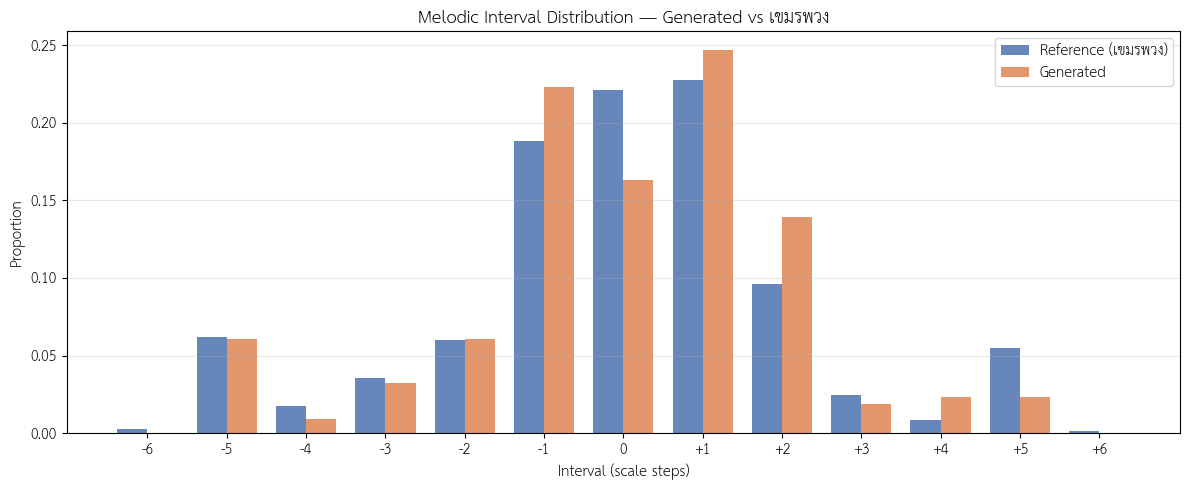


  Interval     Reference     Generated
--------------------------------------
        -6        0.0027        0.0000
        -5        0.0617        0.0605
        -4        0.0178        0.0093
        -3        0.0357        0.0326
        -2        0.0604        0.0605
        -1        0.1879        0.2233
        +0        0.2209        0.1628
        +1        0.2277        0.2465
        +2        0.0960        0.1395
        +3        0.0247        0.0186
        +4        0.0082        0.0233
        +5        0.0549        0.0233
        +6        0.0014        0.0000


{'reference': {0: 0.22085048010973937,
  2: 0.09602194787379972,
  -5: 0.06172839506172839,
  1: 0.22770919067215364,
  -1: 0.18792866941015088,
  -4: 0.01783264746227709,
  5: 0.05486968449931413,
  3: 0.024691358024691357,
  -2: 0.06035665294924554,
  -3: 0.03566529492455418,
  4: 0.00823045267489712,
  -6: 0.0027434842249657062,
  6: 0.0013717421124828531},
 'generated': {0: 0.16279069767441862,
  1: 0.24651162790697675,
  -5: 0.06046511627906977,
  2: 0.13953488372093023,
  -3: 0.03255813953488372,
  -1: 0.22325581395348837,
  -2: 0.06046511627906977,
  5: 0.023255813953488372,
  4: 0.023255813953488372,
  3: 0.018604651162790697,
  -4: 0.009302325581395349}}

In [64]:
evaluate_interval_distribution(combined_slots, EVAL_SONG, songs, normalize_token)


### 5.5 Repetition Score

Measures how much the generated sequence repeats itself.  
`score = (total n-grams − unique n-grams) / total n-grams`  
`0` = every n-gram is unique (maximum variety);  `1` = the sequence is entirely looping.  
The per-segment line plot reveals *where* in the sequence repetition peaks — a common failure mode of LSTMs at higher temperatures is an initial varied section followed by a repetitive plateau.


In [65]:
def compute_repetition_score(slots, normalize_token, n=3):
    """
    Repetition score = proportion of n-grams that are duplicates.
      score = (total - unique) / total  =  1 - type-token ratio
    0 = all unique; 1 = entirely looping.
    """
    tokens = []
    for slot in slots:
        tokens.extend(normalize_token(slot))
    ngrams = [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]
    if not ngrams:
        return 0.0
    counts         = Counter(ngrams)
    duplicate_count = sum(c - 1 for c in counts.values())   # total - unique
    return duplicate_count / len(ngrams)


def evaluate_repetition_score(combined_slots, song_name, songs, normalize_token,
                               n=3, window_bars=2):
    """
    Compute and compare overall repetition scores, then plot per-segment scores
    as a line chart to show where repetition clusters in the sequence.

    Args:
        n           — n-gram order (default 3)
        window_bars — sliding window width in bars (default 2)
    """
    gen_score = compute_repetition_score(combined_slots, normalize_token, n)

    # --- Reference ---
    ref_score  = None
    song_match = next((s for s in songs if s["song"] == song_name), None)
    if song_match:
        # Try slot-level reference first (preserves rhythmic structure)
        ref_slots = []
        for sec in song_match.get("sections", []):
            for bar in sec.get("bars", []):
                if isinstance(bar, list):
                    ref_slots.extend(bar)

        if ref_slots:
            ref_score = compute_repetition_score(ref_slots, normalize_token, n)
        else:
            # Fallback to pitch_sequence (already normalized)
            seq = song_match["pitch_sequence"]
            ngrams = [tuple(seq[i:i + n]) for i in range(len(seq) - n + 1)]
            if ngrams:
                counts    = Counter(ngrams)
                ref_score = sum(c - 1 for c in counts.values()) / len(ngrams)

    print("\n" + "=" * 60)
    print(f"🔁 {n}-GRAM REPETITION SCORE")
    print("=" * 60)
    print(f"Generated : {gen_score:.4f}  ({gen_score * 100:.1f}% of {n}-grams are repeats)")
    if ref_score is not None:
        print(f"Reference : {ref_score:.4f}  ({ref_score * 100:.1f}%)")
    print("=" * 60)

    # --- Per-segment sliding window ---
    window_slots = SLOTS_PER_BAR * window_bars
    scores, bar_positions = [], []

    for start in range(0, len(combined_slots) - window_slots + 1, SLOTS_PER_BAR):
        window = combined_slots[start:start + window_slots]
        scores.append(compute_repetition_score(window, normalize_token, n))
        bar_positions.append(start // SLOTS_PER_BAR)

    if scores:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(bar_positions, scores, marker="o", linewidth=1.5, markersize=4,
                color="#DD8452", label="Generated (per segment)")
        if ref_score is not None:
            ax.axhline(ref_score, color="#4C72B0", linestyle="--", linewidth=1.5,
                       label=f"Reference overall ({song_name})")
        ax.axhline(gen_score, color="grey", linestyle=":", linewidth=1.2, alpha=0.8,
                   label=f"Generated overall: {gen_score:.3f}")
        ax.set_xlabel("Bar index (window start)")
        ax.set_ylabel(f"{n}-gram repetition score")
        ax.set_title(f"Per-Segment {n}-Gram Repetition  (window = {window_bars} bars)")
        ax.legend()
        ax.grid(alpha=0.3)
        ax.set_ylim(0, 1)
        plt.tight_layout()
        plt.show()

    return {
        "generated"   : gen_score,
        "reference"   : ref_score,
        "per_segment" : list(zip(bar_positions, scores)),
    }



🔁 3-GRAM REPETITION SCORE
Generated : 0.4983  (49.8% of 3-grams are repeats)
Reference : 0.7692  (76.9%)


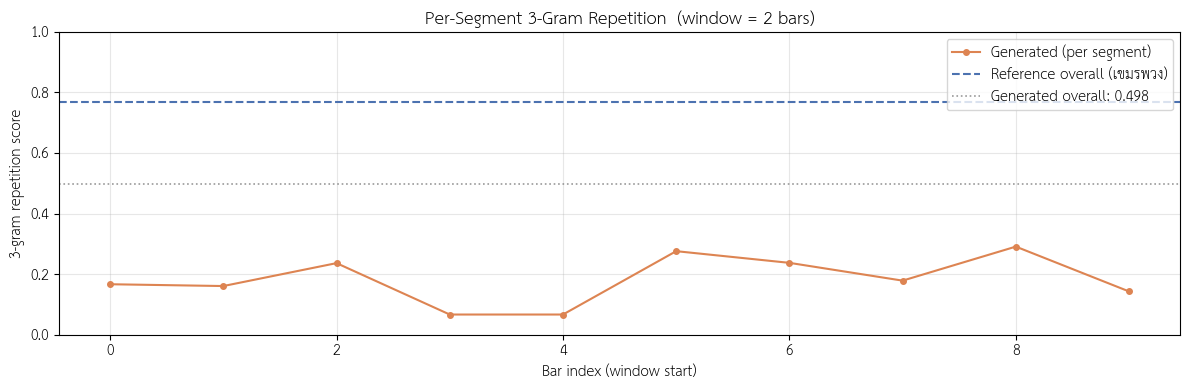

{'generated': 0.49828178694158076,
 'reference': 0.7691542288557214,
 'per_segment': [(0, 0.16666666666666666),
  (1, 0.16071428571428573),
  (2, 0.23636363636363636),
  (3, 0.06666666666666667),
  (4, 0.06666666666666667),
  (5, 0.27586206896551724),
  (6, 0.23728813559322035),
  (7, 0.17857142857142858),
  (8, 0.2909090909090909),
  (9, 0.14285714285714285)]}

In [66]:
evaluate_repetition_score(combined_slots, EVAL_SONG, songs, normalize_token, n=3, window_bars=2)


### 5.6 Corpus N-Gram Overlap

Like 5.2, but the **reference set is the union of all เขมร songs** — not a single reference.  
This avoids the circularity of only comparing against the seed song and gives a truer picture of whether the generated output is stylistically in-distribution for the whole motif.  
Reported for n = 2, 3, 4 with a summary bar chart.


In [67]:
def evaluate_corpus_ngram_overlap(combined_slots, songs, normalize_token, motif="เขมร", n=3):
    """
    Compute n-gram overlap between generated output and the full corpus of `motif`.
    Reference set = union of all pitch_sequence n-gram types for that motif.

    Returns overlap ratio (float) or None if no generated n-grams.
    """
    corpus_ngrams = build_corpus_ngram_set(songs, motif=motif, n=n)

    gen_tokens = []
    for slot in combined_slots:
        gen_tokens.extend(normalize_token(slot))
    gen_ngrams = [tuple(gen_tokens[i:i + n]) for i in range(len(gen_tokens) - n + 1)]

    if not gen_ngrams:
        print("⚠️ No generated n-grams.")
        return None

    overlap_count = sum(1 for g in gen_ngrams if g in corpus_ngrams)
    overlap_ratio = overlap_count / len(gen_ngrams)
    corpus_n_songs = sum(1 for s in songs if s.get("motif") == motif)

    print(f"\n{'=' * 68}")
    print(f"📚 CORPUS {n}-GRAM OVERLAP  —  motif: {motif}  ({corpus_n_songs} songs)")
    print(f"{'=' * 68}")
    print(f"Corpus {n}-gram types  : {len(corpus_ngrams):,}")
    print(f"Generated {n}-grams   : {len(gen_ngrams):,}")
    print(f"Overlap count         : {overlap_count:,}")
    print(f"Overlap ratio         : {overlap_ratio:.4f}  ({overlap_ratio * 100:.1f}%)")
    print(f"{'=' * 68}")

    return overlap_ratio


def evaluate_corpus_ngram_all_n(combined_slots, songs, normalize_token, motif="เขมร"):
    """
    Run corpus n-gram overlap for n = 2, 3, 4 and plot a summary bar chart.
    Returns dict {n: overlap_ratio}.
    """
    ns     = [2, 3, 4]
    ratios = [
        evaluate_corpus_ngram_overlap(combined_slots, songs, normalize_token,
                                      motif=motif, n=n) or 0.0
        for n in ns
    ]

    colors = ["#4C72B0", "#DD8452", "#55A868"]
    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar([f"{n}-gram" for n in ns], ratios, color=colors, alpha=0.85)
    for bar, val in zip(bars, ratios):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{val:.3f}", ha="center", va="bottom", fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Overlap ratio")
    corpus_n_songs = sum(1 for s in songs if s.get("motif") == motif)
    ax.set_title(f"Corpus N-Gram Overlap — {motif} motif  ({corpus_n_songs} songs)")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return dict(zip(ns, ratios))



📚 CORPUS 2-GRAM OVERLAP  —  motif: เขมร  (7 songs)
Corpus 2-gram types  : 93
Generated 2-grams   : 292
Overlap count         : 290
Overlap ratio         : 0.9932  (99.3%)

📚 CORPUS 3-GRAM OVERLAP  —  motif: เขมร  (7 songs)
Corpus 3-gram types  : 469
Generated 3-grams   : 291
Overlap count         : 286
Overlap ratio         : 0.9828  (98.3%)

📚 CORPUS 4-GRAM OVERLAP  —  motif: เขมร  (7 songs)
Corpus 4-gram types  : 1,189
Generated 4-grams   : 290
Overlap count         : 280
Overlap ratio         : 0.9655  (96.6%)


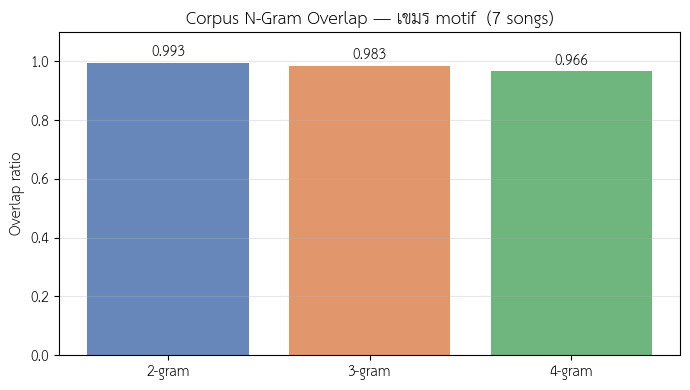

{2: 0.9931506849315068, 3: 0.9828178694158075, 4: 0.9655172413793104}

In [68]:
evaluate_corpus_ngram_all_n(combined_slots, songs, normalize_token, motif="เขมร")


### 5.7 Segment Decay Analysis

Slides a 1-bar window across `combined_slots` and plots its n-gram overlap with the เขมร corpus at each bar position.  
- **Flat line** → the model stays in-style throughout the sequence.  
- **Declining trend** → the model drifts out-of-distribution over time (common with high temperature or long `max_new_tokens`).  
- The green dotted line marks the end of the input fragment, where free generation begins.


In [69]:
def evaluate_segment_decay(combined_slots, songs, normalize_token,
                           motif="เขมร", n=3,
                           segment_bars=1, step_bars=1,
                           fragment=None):
    """
    Sliding-window n-gram overlap against the corpus, plotted across bar positions.
    Visualises whether the model stays in-distribution as the sequence progresses.
    Args:

        combined_slots — flat slot list (fragment + generated continuation)
        songs          — loaded song corpus
        normalize_token— token normalisation function
        motif          — corpus motif to compare against (default "เขมร")
        n              — n-gram order (default 3)
        segment_bars   — window width in bars (default 1)
        step_bars      — step size in bars (default 1 = bar-by-bar)
        fragment       — original input fragment (used to mark seed boundary on plot)

    Returns dict with bar_indices, overlaps, mean.
    """
    segment_slots = SLOTS_PER_BAR * segment_bars
    step_slots    = SLOTS_PER_BAR * step_bars

    corpus_ngrams = build_corpus_ngram_set(songs, motif=motif, n=n)

    bar_indices, overlaps = [], []

    for start in range(0, len(combined_slots) - segment_slots + 1, step_slots):
        window     = combined_slots[start:start + segment_slots]
        win_tokens = []
        for slot in window:
            win_tokens.extend(normalize_token(slot))

        win_ngrams = [tuple(win_tokens[i:i + n]) for i in range(len(win_tokens) - n + 1)]
        if not win_ngrams:
            continue

        overlap = sum(1 for g in win_ngrams if g in corpus_ngrams) / len(win_ngrams)
        overlaps.append(overlap)
        bar_indices.append(start // SLOTS_PER_BAR)

    if not overlaps:
        print("⚠️ Not enough data for segment decay plot.")
        return {}

    mean_overlap     = float(np.mean(overlaps))
    fragment_end_bar = len(fragment) / SLOTS_PER_BAR if fragment is not None else None

    # 3-bar moving average
    if len(overlaps) >= 3:
        smoothed = np.convolve(overlaps, np.ones(3) / 3, mode="valid")
        smooth_x = bar_indices[1: 1 + len(smoothed)]
    else:
        smoothed, smooth_x = np.array([]), []

    fig, ax = plt.subplots(figsize=(13, 4))

    ax.plot(bar_indices, overlaps, marker="o", linewidth=1.2, markersize=4,
            color="#4C72B0", alpha=0.55, label=f"{n}-gram overlap (per bar)")

    if len(smoothed):
        ax.plot(smooth_x, smoothed, linewidth=2.2, color="#4C72B0",
                label="3-bar moving average")

    if fragment_end_bar is not None:
        ax.axvline(fragment_end_bar, color="#2ca02c", linestyle=":",
                   linewidth=1.8, label=f"Fragment end (~bar {fragment_end_bar:.1f})")

    ax.axhline(mean_overlap, color="grey", linestyle="--", linewidth=1.2, alpha=0.7,
               label=f"Mean: {mean_overlap:.3f}")

    ax.set_xlabel("Bar index")
    ax.set_ylabel(f"{n}-gram overlap with {motif} corpus")
    ax.set_title(
        f"Segment Decay Analysis — {n}-gram Overlap vs {motif} Corpus\n"
        f"(window = {segment_bars} bar, step = {step_bars} bar)"
    )
    ax.legend(loc="lower left", fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

    argmin = int(np.argmin(overlaps))
    argmax = int(np.argmax(overlaps))
    print(f"\nMean overlap : {mean_overlap:.4f}")
    print(f"Min  at bar {bar_indices[argmin]} : {overlaps[argmin]:.4f}")
    print(f"Max  at bar {bar_indices[argmax]} : {overlaps[argmax]:.4f}")

    return {"bar_indices": bar_indices, "overlaps": overlaps, "mean": mean_overlap}


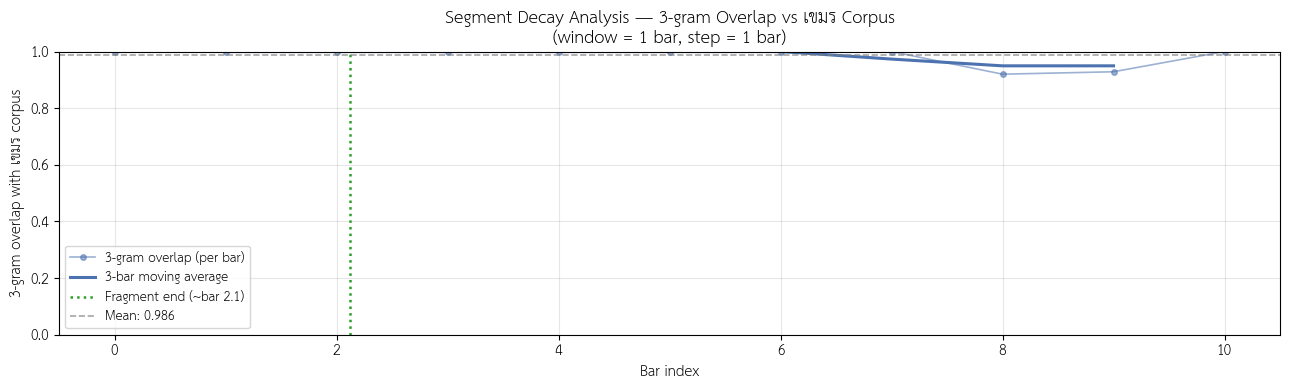


Mean overlap : 0.9862
Min  at bar 8 : 0.9200
Max  at bar 0 : 1.0000


{'bar_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'overlaps': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.92,
  0.9285714285714286,
  1.0],
 'mean': 0.9862337662337662}

In [70]:
evaluate_segment_decay(
    combined_slots, songs, normalize_token,
    motif="เขมร", n=3,
    segment_bars=1, step_bars=1,
    fragment=fragment
)


## 6️⃣ Batch Evaluation Pipeline

Systematically evaluates the model across **multiple songs × multiple temperatures × multiple random seeds**.

Each combination produces a full row of all 6 metrics, which are collected into a pandas DataFrame for analysis.

**Pipeline overview:**
1. **6.1 Config** — define test songs, temperatures, seeds, generation length
2. **6.2 Runner** — `extract_section_seed` extracts the first bar of each section; `run_single_eval` runs one full generate→postprocess→metrics pass; `run_batch_eval` loops over all combos
3. **6.3 Aggregate Table** — group by `(song, temperature)`, report mean ± std per metric
4. **6.4 Visualization Suite** — temperature sweep line plots, per-metric heatmap, segment decay overlay, interval distribution grid, repetition rate overlay

All functions are **motif-agnostic** — pass any `motif=` string to reuse for ลาว, พม่า, etc.


### 6.1 Batch Eval Config

Set the songs, temperatures, seeds, and generation length here.  
Everything downstream reads from these variables — no other cell needs to be touched when you change the config.

- **`BATCH_SONGS`** — list of song names to evaluate (must exist in `songs`)
- **`BATCH_TEMPS`** — temperature sweep values
- **`BATCH_SEEDS`** — independent random seeds per (song × temperature) combo → gives mean ± std
- **`BATCH_MAX_TOKENS`** — generation length per run (240 ≈ 30 bars)
- **`BATCH_MOTIF`** — motif label for corpus n-gram functions; change to `"ลาว"` etc. for other notebooks
- **`BATCH_N`** — n-gram order used across all batch metrics (matches Section 5 default)
- **`BATCH_REF_SONG`** — reference song for single-song metrics (5.1–5.3); can differ from seed songs


In [71]:
# ============================================================
# 6.1  Batch Evaluation Config
# ============================================================

# Songs to evaluate — must match s["song"] values in `songs`
BATCH_SONGS = [
    "เขมรพวง",
    "เขมรเขียว",
    "เขมรไทรโยค",
    "เขมรโพธิสัตว์",
    "เขมรลออองค์",
]

# Temperature sweep
BATCH_TEMPS = [0.8, 1.0, 1.1, 1.3]

# Independent seeds per (song × temperature) combo  → mean ± std over N runs
BATCH_SEEDS = [42, 43, 44, 45, 46]

# Generation length (tokens) per run
BATCH_MAX_TOKENS = 240   # ≈ 30 bars

# Motif label — change to "ลาว", "พม่า" etc. when reusing in another notebook
BATCH_MOTIF = "เขมร"

# n-gram order for all batch metrics
BATCH_N = 3

# Reference song for single-song metrics (REST distribution, n-gram overlap, KL)
BATCH_REF_SONG = "เขมรพวง"

# ── derived (do not edit) ──────────────────────────────────
print(f"Songs  : {len(BATCH_SONGS)}")
print(f"Temps  : {BATCH_TEMPS}")
print(f"Seeds  : {len(BATCH_SEEDS)}  →  {len(BATCH_SONGS) * len(BATCH_TEMPS) * len(BATCH_SEEDS)} total runs")


Songs  : 5
Temps  : [0.8, 1.0, 1.1, 1.3]
Seeds  : 5  →  100 total runs


### 6.2 Batch Runner

**`extract_section_seed(song, section_idx)`** — pulls the first bar (8 slots) of a given section as the raw fragment.  
Handles plain list bars and นำ/ตาม dict bars gracefully.

**`run_single_eval(song_name, section_idx, temperature, seed, ...)`** — one full pipeline pass:  
`extract seed → generate → postprocess → compute all 6 metrics → return dict`

**`run_batch_eval(...)`** — outer loop over `songs × sections × temperatures × seeds`.  
Returns a flat pandas DataFrame — one row per run.

> **Corpus n-gram cache** — `build_corpus_ngram_set` is called once per `(motif, n)` pair before the loop and reused across all runs (it's expensive to recompute ~100× unnecessarily).


In [73]:
import pandas as pd
from tqdm.auto import tqdm

# ============================================================
# Helper: extract first bar of a section as a seed fragment
# ============================================================

def extract_section_seed(song, section_idx=0):
    """
    Return the first bar of song["data"]["sections"][section_idx] as a flat
    list of slot strings.

    Handles:
    - Plain list bars      → ["----", "---ล", ...]
    - Dict bars (นำ/ตาม)   → slots extracted from the first key's value
    - Missing / empty      → returns [] with a warning
    """
    sections = song["data"].get("sections", [])

    if section_idx >= len(sections):
        print(f"⚠️  {song['song']}: section_idx={section_idx} out of range "
              f"({len(sections)} sections)")
        return []

    section  = sections[section_idx]
    bars     = section.get("bars", [])

    if not bars:
        print(f"⚠️  {song['song']} §{section_idx} has no bars.")
        return []

    first_bar = bars[0]

    # Plain list bar
    if isinstance(first_bar, list):
        return [slot for slot in first_bar if isinstance(slot, str)]

    # Dict bar (นำ / ตาม)
    if isinstance(first_bar, dict):
        for key in first_bar:
            val = first_bar[key]
            if isinstance(val, list):
                return [slot for slot in val if isinstance(slot, str)]

    print(f"⚠️  {song['song']} §{section_idx} bar[0] has unrecognised format.")
    return []


# ============================================================
# Helper: compute KL divergence scalar (for batch rows)
# ============================================================

def _kl_scalar(ref_tokens, gen_tokens):
    """KL(P_ref ‖ Q_gen) on 7-note pitch distribution."""
    eps = 1e-8

    def _dist(toks):
        counts = Counter(t for t in toks if t in PITCH_IDX)
        total  = sum(counts.values()) or 1
        return np.array([counts.get(p, 0) / total for p in THAI_PITCHES]) + eps

    return float(np.sum(_dist(ref_tokens) * np.log(_dist(ref_tokens) / _dist(gen_tokens))))


# ============================================================
# Core: single eval run
# ============================================================

def run_single_eval(
    song_name,
    section_idx,
    temperature,
    seed,
    songs,
    model,
    token_to_id,
    id_to_token,
    normalize_token,
    ref_song_name,
    motif,
    n,
    max_new_tokens,
    corpus_ngram_cache,   # pre-built {n: set_of_ngrams}
    seq_len=16,
):
    """
    One full pipeline pass: seed → generate → postprocess → all 6 metrics.

    Returns a flat dict (one DataFrame row), or None on failure.
    """

    # ── find song ──────────────────────────────────────────
    song = next((s for s in songs if s["song"] == song_name), None)
    if song is None:
        print(f"❌ Song '{song_name}' not found.")
        return None

    section_name = "?"
    secs = song["data"].get("sections", [])
    if section_idx < len(secs):
        section_name = secs[section_idx].get("name", str(section_idx))

    # ── extract seed fragment ──────────────────────────────
    fragment = extract_section_seed(song, section_idx)
    if not fragment:
        return None

    # ── generate ──────────────────────────────────────────
    gen_tokens = generate_from_fragment(
        fragment_tokens=fragment,
        model=model,
        token_to_id=token_to_id,
        id_to_token=id_to_token,
        seq_len=seq_len,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        bar_size=32,
        seed=seed,
    )
    if gen_tokens is None:
        return None

    # ── postprocess ───────────────────────────────────────
    combined_slots, _ = postprocess_generated(
        fragment, gen_tokens, seq_len=seq_len, verbose=False
    )

    # ── reference song tokens ─────────────────────────────
    ref_song = next((s for s in songs if s["song"] == ref_song_name), None)
    ref_tokens = ref_song["pitch_sequence"] if ref_song else []

    # ── normalize generated tokens ────────────────────────
    gen_norm = []
    for slot in combined_slots:
        gen_norm.extend(normalize_token(slot))

    # ── Metric 1: REST distribution (χ² distance as scalar) ──
    rest_types  = ["<REST_1>", "<REST_2>", "<REST_3>", "<REST_4>"]
    ref_total_r = sum(1 for t in ref_tokens if t.startswith("<REST")) or 1
    gen_total_r = sum(1 for t in gen_norm   if t.startswith("<REST")) or 1

    rest_chi2 = 0.0
    for r in rest_types:
        p = sum(1 for t in ref_tokens if t == r) / ref_total_r
        q = sum(1 for t in gen_norm   if t == r) / gen_total_r
        rest_chi2 += (p - q) ** 2

    # ── Metric 2: single-song n-gram overlap (vs ref_song) ──
    ref_ngrams = set(
        tuple(ref_tokens[i:i + n]) for i in range(len(ref_tokens) - n + 1)
    )
    gen_ngrams  = [tuple(gen_norm[i:i + n]) for i in range(len(gen_norm) - n + 1)]
    single_overlap = (
        sum(1 for g in gen_ngrams if g in ref_ngrams) / len(gen_ngrams)
        if gen_ngrams else 0.0
    )

    # ── Metric 3: pitch KL divergence ──────────────────────
    kl = _kl_scalar(ref_tokens, gen_norm) if ref_tokens else float("nan")

    # ── Metric 4: corpus n-gram overlap ────────────────────
    corpus_set = corpus_ngram_cache.get(n, set())
    corpus_overlap = (
        sum(1 for g in gen_ngrams if g in corpus_set) / len(gen_ngrams)
        if gen_ngrams else 0.0
    )

    # ── Metric 5: overall repetition score ─────────────────
    rep_score = compute_repetition_score(combined_slots, normalize_token, n=n)

    # ── Metric 6: segment decay mean ───────────────────────
    seg_window  = SLOTS_PER_BAR           # 1-bar window (matches 5.7 default)
    seg_overlaps = []
    for start in range(0, len(combined_slots) - seg_window + 1, seg_window):
        window     = combined_slots[start:start + seg_window]
        win_toks   = []
        for slot in window:
            win_toks.extend(normalize_token(slot))
        win_ng = [tuple(win_toks[i:i + n]) for i in range(len(win_toks) - n + 1)]
        if win_ng:
            seg_overlaps.append(
                sum(1 for g in win_ng if g in corpus_set) / len(win_ng)
            )
    seg_decay_mean = float(np.mean(seg_overlaps)) if seg_overlaps else float("nan")

    return {
        "song"            : song_name,
        "section_idx"     : section_idx,
        "section_name"    : section_name,
        "temperature"     : temperature,
        "seed"            : seed,
        "rest_chi2"       : round(rest_chi2,       6),
        "single_overlap"  : round(single_overlap,  6),
        "pitch_kl"        : round(kl,              6),
        "corpus_overlap"  : round(corpus_overlap,  6),
        "repetition_score": round(rep_score,        6),
        "seg_decay_mean"  : round(seg_decay_mean,  6),
    }


In [74]:
def run_batch_eval(
    batch_songs,
    batch_temps,
    batch_seeds,
    songs,
    model,
    token_to_id,
    id_to_token,
    normalize_token,
    ref_song_name,
    motif,
    n,
    max_new_tokens,
    seq_len=16,
):
    """
    Outer batch loop: songs × all-sections × temperatures × seeds.

    For each song every section is used as a seed origin, giving broader
    coverage than a single section.  Sections with < 1 bar are skipped.

    Returns a pandas DataFrame with one row per run.
    """

    # ── Pre-build corpus n-gram set once (expensive) ──────
    print(f"Building corpus n-gram set for motif '{motif}', n={n} …")
    corpus_ngram_cache = {n: build_corpus_ngram_set(songs, motif=motif, n=n)}
    print(f"  → {len(corpus_ngram_cache[n]):,} unique {n}-gram types in corpus\n")

    rows  = []
    total = (
        sum(len(s["data"].get("sections", [])) for s in songs
            if s["song"] in batch_songs)
        * len(batch_temps)
        * len(batch_seeds)
    )

    with tqdm(total=total, desc="Batch eval") as pbar:
        for song_name in batch_songs:
            song = next((s for s in songs if s["song"] == song_name), None)
            if song is None:
                print(f"⚠️  '{song_name}' not in loaded songs — skipping.")
                continue

            sections = song["data"].get("sections", [])

            for sec_idx in range(len(sections)):
                for temp in batch_temps:
                    for seed in batch_seeds:
                        row = run_single_eval(
                            song_name       = song_name,
                            section_idx     = sec_idx,
                            temperature     = temp,
                            seed            = seed,
                            songs           = songs,
                            model           = model,
                            token_to_id     = token_to_id,
                            id_to_token     = id_to_token,
                            normalize_token = normalize_token,
                            ref_song_name   = ref_song_name,
                            motif           = motif,
                            n               = n,
                            max_new_tokens  = max_new_tokens,
                            corpus_ngram_cache = corpus_ngram_cache,
                            seq_len         = seq_len,
                        )
                        if row is not None:
                            rows.append(row)
                        pbar.update(1)

    df = pd.DataFrame(rows)
    print(f"\n✅ Batch complete — {len(df)} rows collected.")
    return df

print("✅ run_batch_eval defined")


✅ run_batch_eval defined


### 6.3 Aggregate Results Table

Groups by `(song, temperature)` and reports **mean ± std** for every metric.  
A second summary groups by `temperature` only (averaged across all songs + sections) — this is the primary table for the thesis temperature-sweep analysis.


In [77]:
METRIC_COLS = [
    "rest_chi2",
    "single_overlap",
    "pitch_kl",
    "corpus_overlap",
    "repetition_score",
    "seg_decay_mean",
]

METRIC_LABELS = {
    "rest_chi2"        : "REST χ² dist ↓",
    "single_overlap"   : f"Single {BATCH_N}-gram overlap ↑",
    "pitch_kl"         : "Pitch KL div ↓",
    "corpus_overlap"   : f"Corpus {BATCH_N}-gram overlap ↑",
    "repetition_score" : "Repetition score ↓",
    "seg_decay_mean"   : "Seg decay mean ↑",
}


def make_aggregate_table(df):
    """
    Print two aggregate tables from the batch eval DataFrame:

    Table A — (song × temperature): mean ± std per metric
    Table B — temperature only (all songs pooled): mean ± std per metric

    Also returns (agg_song_temp, agg_temp) as DataFrames.
    """

    def fmt(mean, std):
        return f"{mean:.4f} ± {std:.4f}"

    # ── Table A: song × temperature ────────────────────────
    grp_a = df.groupby(["song", "temperature"])[METRIC_COLS]
    mean_a = grp_a.mean()
    std_a  = grp_a.std(ddof=1).fillna(0)

    rows_a = []
    for (song, temp), m_row in mean_a.iterrows():
        s_row = std_a.loc[(song, temp)]
        entry = {"song": song, "temperature": temp}
        for col in METRIC_COLS:
            entry[METRIC_LABELS[col]] = fmt(m_row[col], s_row[col])
        rows_a.append(entry)

    agg_a = pd.DataFrame(rows_a).set_index(["song", "temperature"])

    print("\n" + "=" * 80)
    print("TABLE A — Mean ± Std per (Song × Temperature)")
    print("=" * 80)
    print(agg_a.to_string())

    # ── Table B: temperature only ──────────────────────────
    grp_b  = df.groupby("temperature")[METRIC_COLS]
    mean_b = grp_b.mean()
    std_b  = grp_b.std(ddof=1).fillna(0)

    rows_b = []
    for temp, m_row in mean_b.iterrows():
        s_row = std_b.loc[temp]
        entry = {"temperature": temp}
        for col in METRIC_COLS:
            entry[METRIC_LABELS[col]] = fmt(m_row[col], s_row[col])
        rows_b.append(entry)

    agg_b = pd.DataFrame(rows_b).set_index("temperature")

    print("\n" + "=" * 80)
    print("TABLE B — Mean ± Std per Temperature  (all songs pooled)")
    print("=" * 80)
    print(agg_b.to_string())

    return agg_a, agg_b

print("✅ make_aggregate_table defined")


✅ make_aggregate_table defined


### 6.4 Visualization Suite

Five plots — all generated from `batch_df` produced by `run_batch_eval`:

1. **Temperature sweep** — line plot of each metric's mean vs temperature (all songs pooled), with ± std shading
2. **Per-metric heatmap** — rows = songs, columns = temperatures; colour = metric mean
3. **Segment decay overlay** — re-runs 5.7-style decay for one representative run at each temperature on a shared axis
4. **Interval distribution grid** — one bar chart per temperature, reference overlaid in each panel
5. **Repetition rate overlay** — per-segment repetition curves for each temperature on one plot


In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Colour palette — one colour per temperature (up to 8)
_TEMP_PALETTE = ["#4C72B0", "#55A868", "#DD8452", "#C44E52",
                 "#8172B2", "#937860", "#DA8BC3", "#8C8C8C"]


# ── Plot 1: Temperature sweep line plot ───────────────────

def plot_temperature_sweep(df, metric_cols=None, title_suffix=""):
    """
    For each metric: mean ± std across all songs, plotted vs temperature.
    Useful for seeing the stability–creativity trade-off at a glance.
    """
    if metric_cols is None:
        metric_cols = METRIC_COLS

    temps = sorted(df["temperature"].unique())
    grp   = df.groupby("temperature")[metric_cols]
    means = grp.mean()
    stds  = grp.std(ddof=1).fillna(0)

    ncols = 3
    nrows = -(-len(metric_cols) // ncols)   # ceiling division
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), squeeze=False)

    for idx, col in enumerate(metric_cols):
        ax  = axes[idx // ncols][idx % ncols]
        mu  = means[col].values
        sig = stds[col].values

        ax.plot(temps, mu, marker="o", linewidth=2, color="#4C72B0")
        ax.fill_between(temps,
                        mu - sig, mu + sig,
                        alpha=0.2, color="#4C72B0")
        ax.set_title(METRIC_LABELS.get(col, col), fontsize=10)
        ax.set_xlabel("Temperature")
        ax.set_xticks(temps)
        ax.grid(alpha=0.3)

    # Hide unused panels
    for idx in range(len(metric_cols), nrows * ncols):
        axes[idx // ncols][idx % ncols].set_visible(False)

    fig.suptitle(f"Temperature Sweep — Mean ± Std per Metric{title_suffix}",
                 fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()


# ── Plot 2: Per-metric heatmap (song × temperature) ───────

def plot_metric_heatmap(df, metric_cols=None, title_suffix=""):
    """
    One heatmap per metric.  Rows = songs, columns = temperatures.
    Values = mean across all sections and seeds for that (song, temp).
    """
    if metric_cols is None:
        metric_cols = METRIC_COLS

    songs_order = sorted(df["song"].unique())
    temps_order = sorted(df["temperature"].unique())
    pivot_data  = df.groupby(["song", "temperature"])[metric_cols].mean()

    ncols = 3
    nrows = -(-len(metric_cols) // ncols)
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(5 * ncols, 3.5 * nrows), squeeze=False)

    for idx, col in enumerate(metric_cols):
        ax  = axes[idx // ncols][idx % ncols]
        mat = np.array([
            [pivot_data.loc[(s, t), col]
             if (s, t) in pivot_data.index else np.nan
             for t in temps_order]
            for s in songs_order
        ])
        im = ax.imshow(mat, aspect="auto", cmap="YlOrRd_r",
                       vmin=np.nanmin(mat), vmax=np.nanmax(mat))
        ax.set_xticks(range(len(temps_order)))
        ax.set_xticklabels([str(t) for t in temps_order], fontsize=9)
        ax.set_yticks(range(len(songs_order)))
        ax.set_yticklabels(songs_order, fontsize=8)
        ax.set_title(METRIC_LABELS.get(col, col), fontsize=9)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Annotate cells
        for ri in range(len(songs_order)):
            for ci in range(len(temps_order)):
                v = mat[ri, ci]
                if not np.isnan(v):
                    ax.text(ci, ri, f"{v:.3f}", ha="center", va="center",
                            fontsize=7,
                            color="white" if v < (np.nanmin(mat) + np.nanmax(mat)) / 2
                            else "black")

    for idx in range(len(metric_cols), nrows * ncols):
        axes[idx // ncols][idx % ncols].set_visible(False)

    fig.suptitle(f"Per-Metric Heatmap — Song × Temperature{title_suffix}",
                 fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()


# ── Plot 3: Segment decay overlay (one curve per temperature) ──

def plot_segment_decay_overlay(
    batch_songs, batch_temps, songs, model,
    token_to_id, id_to_token, normalize_token,
    motif, n, max_new_tokens, seq_len=16,
    ref_seed=42, section_idx=0, title_suffix=""
):
    """
    For the first song in batch_songs, re-runs generation at each temperature
    (fixed seed=ref_seed, section_idx=0) and overlays the segment decay curves.
    """
    corpus_set = build_corpus_ngram_set(songs, motif=motif, n=n)

    song_name = batch_songs[0]
    song      = next((s for s in songs if s["song"] == song_name), None)
    if song is None:
        print(f"❌ '{song_name}' not found.")
        return

    fragment = extract_section_seed(song, section_idx)
    if not fragment:
        return

    fig, ax = plt.subplots(figsize=(13, 4))

    for t_idx, temp in enumerate(batch_temps):
        color = _TEMP_PALETTE[t_idx % len(_TEMP_PALETTE)]

        gen_tokens = generate_from_fragment(
            fragment_tokens=fragment, model=model,
            token_to_id=token_to_id, id_to_token=id_to_token,
            seq_len=seq_len, max_new_tokens=max_new_tokens,
            temperature=temp, bar_size=32, seed=ref_seed,
        )
        if gen_tokens is None:
            continue

        combined, _ = postprocess_generated(fragment, gen_tokens,
                                            seq_len=seq_len, verbose=False)

        bar_indices, overlaps = [], []
        for start in range(0, len(combined) - SLOTS_PER_BAR + 1, SLOTS_PER_BAR):
            window    = combined[start:start + SLOTS_PER_BAR]
            win_toks  = []
            for slot in window:
                win_toks.extend(normalize_token(slot))
            win_ng = [tuple(win_toks[i:i + n]) for i in range(len(win_toks) - n + 1)]
            if win_ng:
                overlaps.append(
                    sum(1 for g in win_ng if g in corpus_set) / len(win_ng)
                )
                bar_indices.append(start // SLOTS_PER_BAR)

        ax.plot(bar_indices, overlaps, linewidth=1.5, alpha=0.8,
                color=color, label=f"temp={temp}")

    frag_end = len(fragment) / SLOTS_PER_BAR
    ax.axvline(frag_end, color="green", linestyle=":", linewidth=1.5,
               label=f"Fragment end (~bar {frag_end:.1f})")
    ax.set_xlabel("Bar index")
    ax.set_ylabel(f"{n}-gram overlap with {motif} corpus")
    ax.set_title(
        f"Segment Decay Overlay — {song_name} (seed={ref_seed}){title_suffix}"
    )
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


# ── Plot 4: Interval distribution grid (one panel per temperature) ──

def plot_interval_distribution_grid(
    batch_songs, batch_temps, songs, model,
    token_to_id, id_to_token, normalize_token,
    ref_song_name, motif, n, max_new_tokens, seq_len=16,
    ref_seed=42, section_idx=0, title_suffix=""
):
    """
    One grouped bar chart per temperature.  Uses the first song in batch_songs
    as the seed source.  Reference distribution is overlaid in each panel.
    """
    song_name = batch_songs[0]
    song      = next((s for s in songs if s["song"] == song_name), None)
    if song is None:
        return

    fragment  = extract_section_seed(song, section_idx)
    if not fragment:
        return

    ref_song  = next((s for s in songs if s["song"] == ref_song_name), None)
    ref_pitch = _seq_to_pitch_tokens(ref_song["pitch_sequence"]) if ref_song else []
    ref_dist  = _interval_dist(ref_pitch)

    ncols = len(batch_temps)
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 4), sharey=True)
    if ncols == 1:
        axes = [axes]

    for ax, temp in zip(axes, batch_temps):
        gen_tokens = generate_from_fragment(
            fragment_tokens=fragment, model=model,
            token_to_id=token_to_id, id_to_token=id_to_token,
            seq_len=seq_len, max_new_tokens=max_new_tokens,
            temperature=temp, bar_size=32, seed=ref_seed,
        )
        if gen_tokens is None:
            ax.set_title(f"temp={temp}\n(failed)")
            continue

        combined, _ = postprocess_generated(fragment, gen_tokens,
                                            seq_len=seq_len, verbose=False)
        gen_pitch = _slots_to_pitch_tokens(combined, normalize_token)
        gen_dist  = _interval_dist(gen_pitch)

        all_ivs  = sorted(set(ref_dist) | set(gen_dist))
        x        = np.arange(len(all_ivs))
        width    = 0.38

        ax.bar(x - width / 2,
               [ref_dist.get(iv, 0) for iv in all_ivs],
               width, color="#4C72B0", alpha=0.8, label="Reference")
        ax.bar(x + width / 2,
               [gen_dist.get(iv, 0) for iv in all_ivs],
               width, color="#DD8452", alpha=0.8, label="Generated")

        ax.set_title(f"temp = {temp}", fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels([f"{iv:+d}" if iv != 0 else "0"
                            for iv in all_ivs], fontsize=7)
        ax.set_xlabel("Interval (scale steps)")
        ax.grid(axis="y", alpha=0.3)
        if ax is axes[0]:
            ax.set_ylabel("Proportion")
            ax.legend(fontsize=8)

    fig.suptitle(
        f"Interval Distribution by Temperature — {song_name}{title_suffix}",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()


# ── Plot 5: Repetition rate overlay (one curve per temperature) ──

def plot_repetition_overlay(
    batch_songs, batch_temps, songs, model,
    token_to_id, id_to_token, normalize_token,
    motif, n, max_new_tokens, seq_len=16,
    ref_seed=42, section_idx=0,
    window_bars=2, title_suffix=""
):
    """
    Per-segment repetition score for each temperature, overlaid on one axes.
    Reveals whether higher temperatures cause earlier or deeper repetition.
    """
    song_name = batch_songs[0]
    song      = next((s for s in songs if s["song"] == song_name), None)
    if song is None:
        return

    fragment = extract_section_seed(song, section_idx)
    if not fragment:
        return

    window_slots = SLOTS_PER_BAR * window_bars
    fig, ax = plt.subplots(figsize=(13, 4))

    for t_idx, temp in enumerate(batch_temps):
        color = _TEMP_PALETTE[t_idx % len(_TEMP_PALETTE)]

        gen_tokens = generate_from_fragment(
            fragment_tokens=fragment, model=model,
            token_to_id=token_to_id, id_to_token=id_to_token,
            seq_len=seq_len, max_new_tokens=max_new_tokens,
            temperature=temp, bar_size=32, seed=ref_seed,
        )
        if gen_tokens is None:
            continue

        combined, _ = postprocess_generated(fragment, gen_tokens,
                                            seq_len=seq_len, verbose=False)

        scores, bar_positions = [], []
        for start in range(0, len(combined) - window_slots + 1, SLOTS_PER_BAR):
            window  = combined[start:start + window_slots]
            scores.append(compute_repetition_score(window, normalize_token, n=n))
            bar_positions.append(start // SLOTS_PER_BAR)

        ax.plot(bar_positions, scores, linewidth=1.5, alpha=0.8,
                color=color, label=f"temp={temp}")

    frag_end = len(fragment) / SLOTS_PER_BAR
    ax.axvline(frag_end, color="green", linestyle=":", linewidth=1.5,
               label=f"Fragment end (~bar {frag_end:.1f})")
    ax.set_xlabel("Bar index (window start)")
    ax.set_ylabel(f"{n}-gram repetition score")
    ax.set_title(
        f"Repetition Rate Overlay — {song_name} "
        f"(window={window_bars} bars){title_suffix}"
    )
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


print("✅ All 5 visualization functions defined")


✅ All 5 visualization functions defined


### 6.5 Run Batch + Display Results

Run the batch pipeline, print aggregate tables, then render all 5 visualizations.  
Re-run only this section after changing config in 6.1 — no need to re-run 6.2–6.4.


In [84]:
# ── Run batch evaluation ───────────────────────────────────
batch_df = run_batch_eval(
    batch_songs     = BATCH_SONGS,
    batch_temps     = BATCH_TEMPS,
    batch_seeds     = BATCH_SEEDS,
    songs           = songs,
    model           = model,
    token_to_id     = token_to_id,
    id_to_token     = id_to_token,
    normalize_token = normalize_token,
    ref_song_name   = BATCH_REF_SONG,
    motif           = BATCH_MOTIF,
    n               = BATCH_N,
    max_new_tokens  = BATCH_MAX_TOKENS,
    seq_len         = SEQ_LEN,
)

# ── Aggregate tables ───────────────────────────────────────
agg_song_temp, agg_temp = make_aggregate_table(batch_df)

# ── Optional: save raw results to CSV ─────────────────────
csv_path = DATA_ROOT / "batch_eval_results_khmer.csv"
batch_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"\n💾 Raw results saved → {csv_path}")


Building corpus n-gram set for motif 'เขมร', n=3 …
  → 469 unique 3-gram types in corpus



Batch eval:   0%|          | 0/540 [00:00<?, ?it/s]


GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, --ดล, ซฟซล, --รด, ลด-ร
----, ----, -ฟซล, -ด-ร, -ฟ-ด, รฟ-ร, ---ด, ---ล
----, ---ล, -ลลล, -ล-ล, ซลดร, ฟดรฟ, ดรฟซ, ลฟซล
-ซ-ซ, ---ล, ---ด, -ร-ฟ, ---ร, -ด-ฟ, ---ร, -ด-ล
----, ----, -รดล, รดลซ, ดลซฟ, ลซฟร, -รฟร, ฟด-ร
-ม-ม, -ม-ม, -ม-ม, -ฟ-ฟ, ---ร, ---ด, ---ล, -ฟซล
-ด-ร, ----, ----, ----, ลลลล, --ดด, รดลซ, --ลล
ดลซฟ, --ซซ, ลซฟร, ----, ----, -ฟซล, -ด-ร, -ฟ-ด
รฟ-ร, ---ด, ---ล, ----, ---ล, -ลลล, -ล-ล, ซลดร
ฟดร
✅ Post-processing done — 89 slots  (2 bars)

GENERATED continuation:

---ฟ, ---ซ, ---ล, ---ซ, -ฟ-ล, -ซ-ฟ, ---ด, -ฟ--
-ลซฟ, -ด-ฟ, ---ซ, -ล--, -ด-ร, -ด-ล, ---ซ, -ล--
-ด-ล, -ร-ด, -ล-ร, ดลดล, ซฟมร, มซมร, ดดซล, ดซลร
ดลดร, ดลดซ, -ล-ด, รดลด, -ร-ฟ, ----, ---ฟ, -ฟฟฟ
-ฟ-ฟ, ลรดล, ดรดด, ฟรดร, ฟซฟฟ, ---ล, ---ซ, ---ฟ
ลซฟร, ฟรดล, -ด-ร, ฟรฟด, ฟร--, ฟด-ร, -ฟ--, ----
-ล-ซ, ฟซ-ล, -ดรซ, ฟร-ฟ, -ร-ด, -ล-ซ, -ฟ--, ฟฟ-ฟ
--ฟร, ดล-ด, -ร--, รรซล, ดรฟซ, ฟร-ท, -ล--, ลลดซ
ลดฟร, ดลดล, ซฟลซ, ฟซ-ล, -ดฟร, ดร
✅ Post-processing don

/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:49: UserWarning: Glyph 967 (\N{GREEK SMALL LETTER CHI}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:49: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:49: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 967 (\N{GREEK SMALL LETTER CHI}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_i

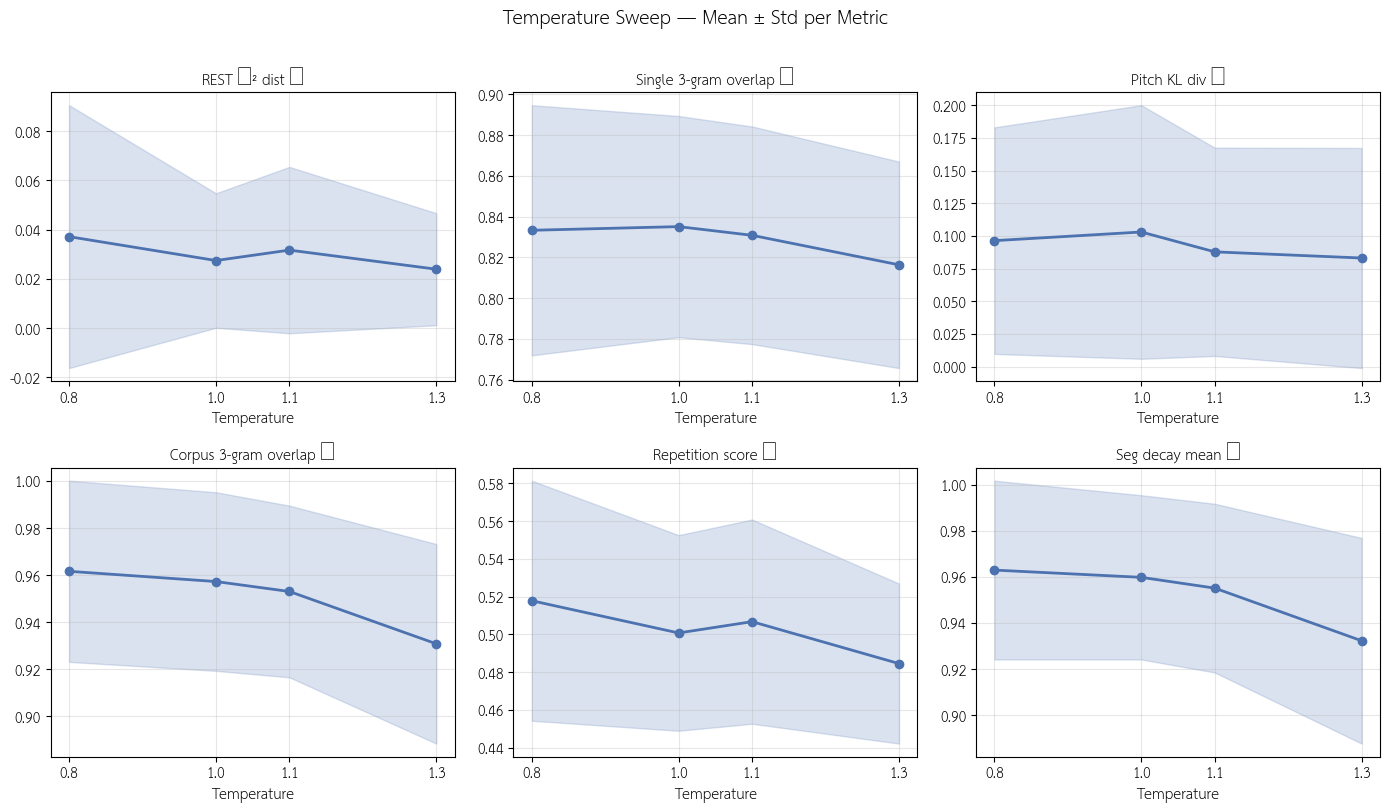

/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:104: UserWarning: Glyph 967 (\N{GREEK SMALL LETTER CHI}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:104: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_82571/3592994745.py:104: UserWarning: Glyph 8593 (\N{UPWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 967 (\N{GREEK SMALL LETTER CHI}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8595 (\N{DOWNWARDS ARROW}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(byte

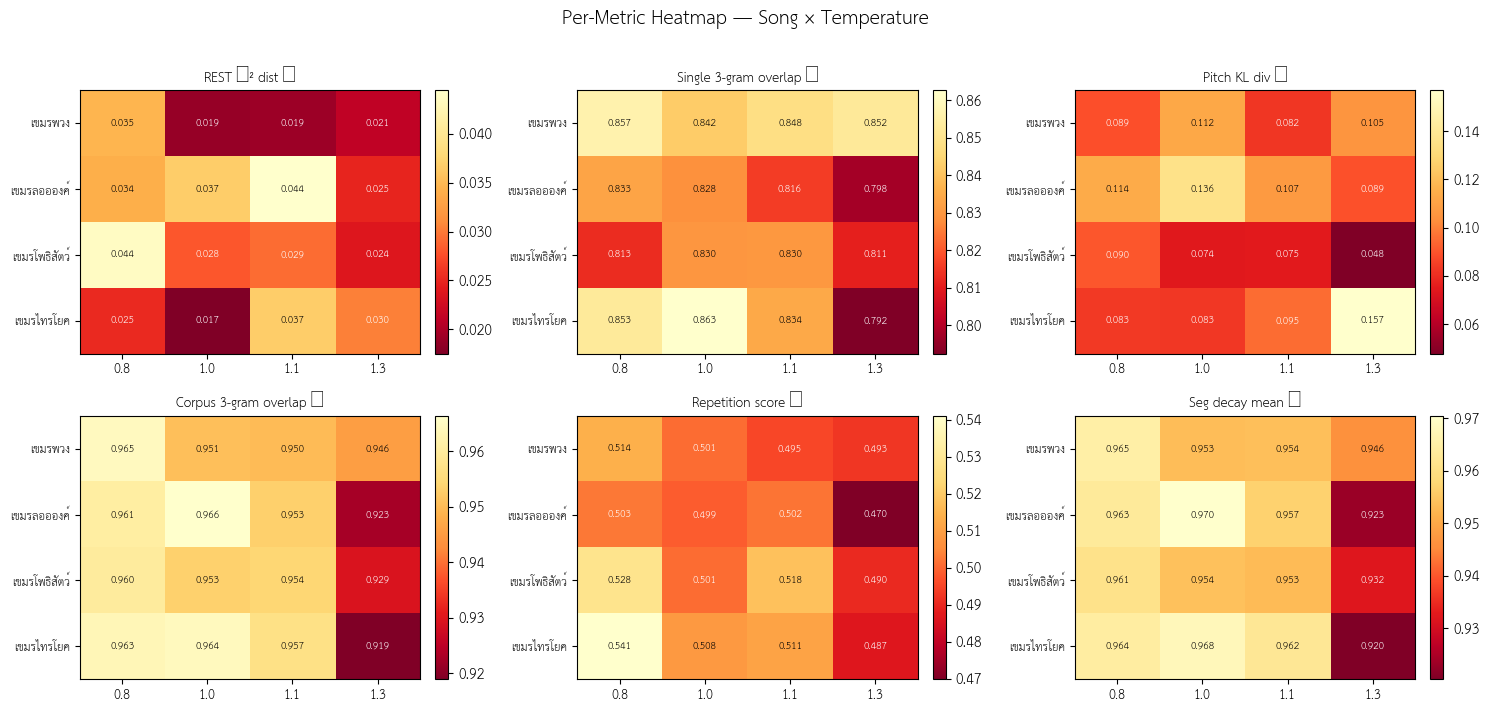


GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, --ดล, ซฟซล, --รด, ลด-ร
----, ----, -ฟซล, -ด-ร, -ฟ-ด, รฟ-ร, ---ด, ---ล
----, ---ล, -ลลล, -ล-ล, ซลดร, ฟดรฟ, ดรฟซ, ลฟซล
-ซ-ซ, ---ล, ---ด, -ร-ฟ, ---ร, -ด-ฟ, ---ร, -ด-ล
----, ----, -รดล, รดลซ, ดลซฟ, ลซฟร, -รฟร, ฟด-ร
-ม-ม, -ม-ม, -ม-ม, -ฟ-ฟ, ---ร, ---ด, ---ล, -ฟซล
-ด-ร, ----, ----, ----, ลลลล, --ดด, รดลซ, --ลล
ดลซฟ, --ซซ, ลซฟร, ----, ----, -ฟซล, -ด-ร, -ฟ-ด
รฟ-ร, ---ด, ---ล, ----, ---ล, -ลลล, -ล-ล, ซลดร
ฟดร
✅ Post-processing done — 89 slots  (2 bars)

GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, -ด--, ซลดร, ดรมฟ, ซลซล
ดรฟร, ฟดรด, ลดรฟ, -ร--, -ฟ--, -ร--, -ด--, -ล-ฟ
ซล-ด, -ร--, ----, ----, รดลด, -ร-ฟ, ----, ---ฟ
-ฟฟฟ, -ฟ-ฟ, ลซฟร, ฟดรฟ, รดลด, รฟรด, ล-ดซ, ลดรด
ล-ดร, ดลดร, ฟ-ร-, --ล-, --ด-, --ร-, --ฟ-, --ร-
ฟ-ร-, ด-ล-, -ดลซ, ฟ-ซ-, ---ฟ, ซลด-, ร-ด-, ล-ซ-
-ฟรฟ, ซ--ล, ซดล-, ซ-ฟ-, -ดฟซ, ลทด-, --รด, ดดด-
ร-ด-, ล-ด-, ร-ฟ-, --ฟ-, --ร-, -ดรด, ล-ด-, ----
----, -

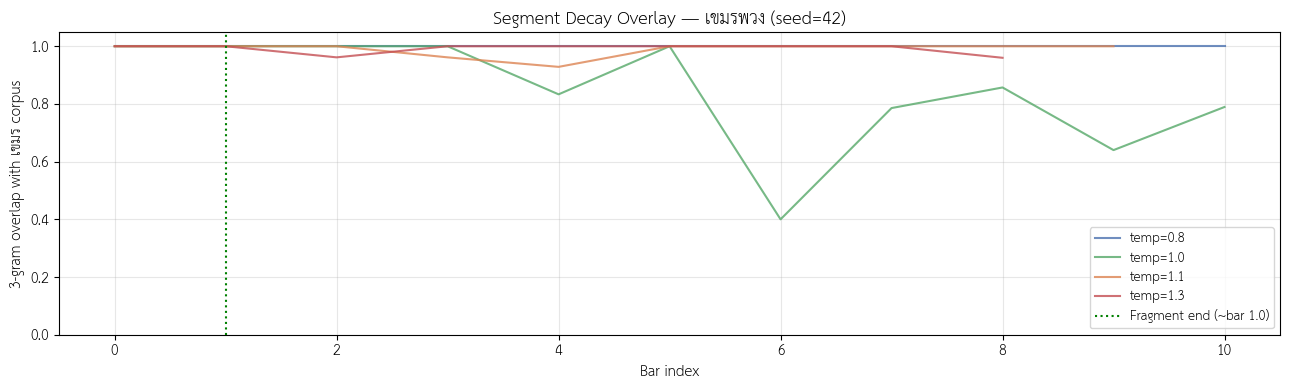


GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, --ดล, ซฟซล, --รด, ลด-ร
----, ----, -ฟซล, -ด-ร, -ฟ-ด, รฟ-ร, ---ด, ---ล
----, ---ล, -ลลล, -ล-ล, ซลดร, ฟดรฟ, ดรฟซ, ลฟซล
-ซ-ซ, ---ล, ---ด, -ร-ฟ, ---ร, -ด-ฟ, ---ร, -ด-ล
----, ----, -รดล, รดลซ, ดลซฟ, ลซฟร, -รฟร, ฟด-ร
-ม-ม, -ม-ม, -ม-ม, -ฟ-ฟ, ---ร, ---ด, ---ล, -ฟซล
-ด-ร, ----, ----, ----, ลลลล, --ดด, รดลซ, --ลล
ดลซฟ, --ซซ, ลซฟร, ----, ----, -ฟซล, -ด-ร, -ฟ-ด
รฟ-ร, ---ด, ---ล, ----, ---ล, -ลลล, -ล-ล, ซลดร
ฟดร
✅ Post-processing done — 89 slots  (2 bars)

GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, -ด--, ซลดร, ดรมฟ, ซลซล
ดรฟร, ฟดรด, ลดรฟ, -ร--, -ฟ--, -ร--, -ด--, -ล-ฟ
ซล-ด, -ร--, ----, ----, รดลด, -ร-ฟ, ----, ---ฟ
-ฟฟฟ, -ฟ-ฟ, ลซฟร, ฟดรฟ, รดลด, รฟรด, ล-ดซ, ลดรด
ล-ดร, ดลดร, ฟ-ร-, --ล-, --ด-, --ร-, --ฟ-, --ร-
ฟ-ร-, ด-ล-, -ดลซ, ฟ-ซ-, ---ฟ, ซลด-, ร-ด-, ล-ซ-
-ฟรฟ, ซ--ล, ซดล-, ซ-ฟ-, -ดฟซ, ลทด-, --รด, ดดด-
ร-ด-, ล-ด-, ร-ฟ-, --ฟ-, --ร-, -ดรด, ล-ด-, ----
----, -

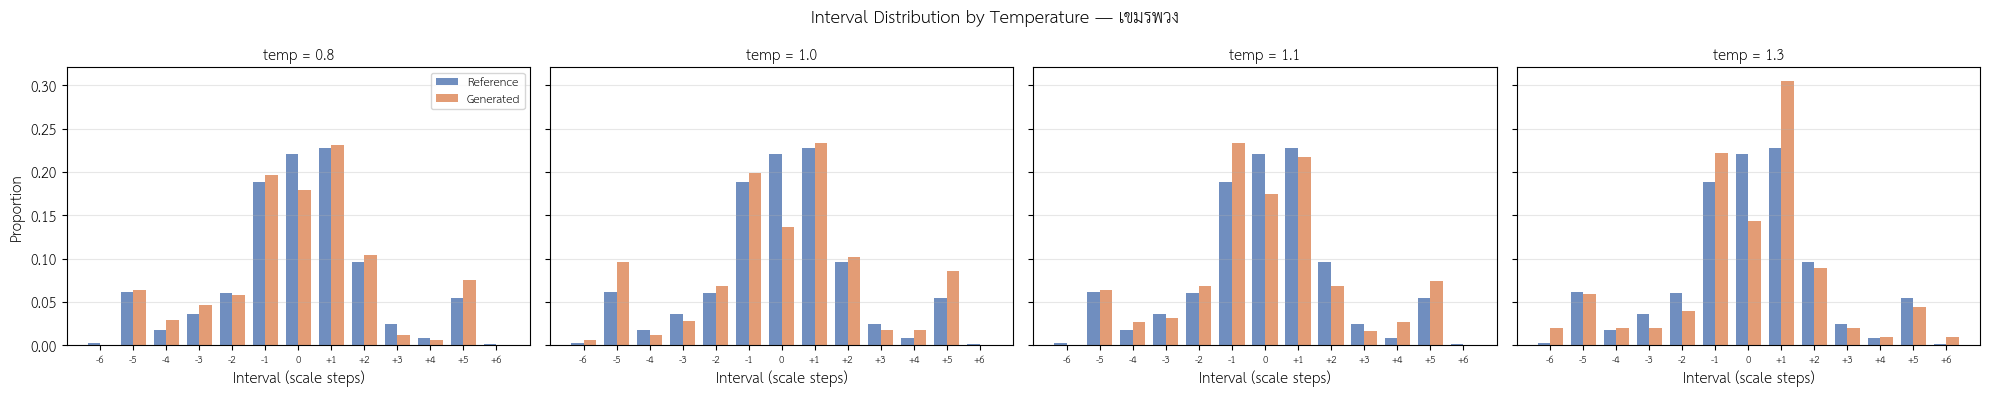


GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, --ดล, ซฟซล, --รด, ลด-ร
----, ----, -ฟซล, -ด-ร, -ฟ-ด, รฟ-ร, ---ด, ---ล
----, ---ล, -ลลล, -ล-ล, ซลดร, ฟดรฟ, ดรฟซ, ลฟซล
-ซ-ซ, ---ล, ---ด, -ร-ฟ, ---ร, -ด-ฟ, ---ร, -ด-ล
----, ----, -รดล, รดลซ, ดลซฟ, ลซฟร, -รฟร, ฟด-ร
-ม-ม, -ม-ม, -ม-ม, -ฟ-ฟ, ---ร, ---ด, ---ล, -ฟซล
-ด-ร, ----, ----, ----, ลลลล, --ดด, รดลซ, --ลล
ดลซฟ, --ซซ, ลซฟร, ----, ----, -ฟซล, -ด-ร, -ฟ-ด
รฟ-ร, ---ด, ---ล, ----, ---ล, -ลลล, -ล-ล, ซลดร
ฟดร
✅ Post-processing done — 89 slots  (2 bars)

GENERATED continuation:

---ด, ---ล, ---ซ, ---ฟ, -ลซฟ, -ด-ฟ, --ลซ, ฟซ-ล
----, ----, ---ซ, ---ล, -ด--, ซลดร, ดรมฟ, ซลซล
ดรฟร, ฟดรด, ลดรฟ, -ร--, -ฟ--, -ร--, -ด--, -ล-ฟ
ซล-ด, -ร--, ----, ----, รดลด, -ร-ฟ, ----, ---ฟ
-ฟฟฟ, -ฟ-ฟ, ลซฟร, ฟดรฟ, รดลด, รฟรด, ล-ดซ, ลดรด
ล-ดร, ดลดร, ฟ-ร-, --ล-, --ด-, --ร-, --ฟ-, --ร-
ฟ-ร-, ด-ล-, -ดลซ, ฟ-ซ-, ---ฟ, ซลด-, ร-ด-, ล-ซ-
-ฟรฟ, ซ--ล, ซดล-, ซ-ฟ-, -ดฟซ, ลทด-, --รด, ดดด-
ร-ด-, ล-ด-, ร-ฟ-, --ฟ-, --ร-, -ดรด, ล-ด-, ----
----, -

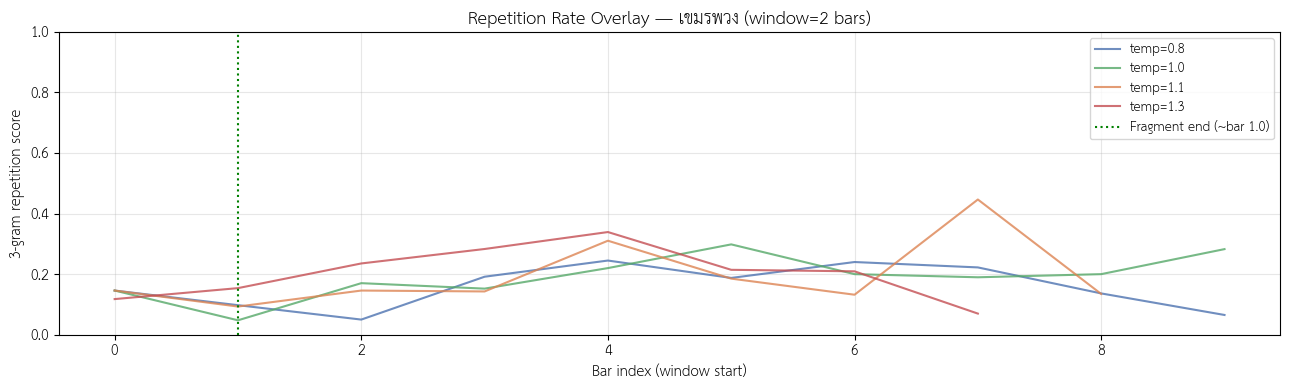

In [85]:
# ── Visualization Suite ────────────────────────────────────
# Shared kwargs for the re-generation plots (3, 4, 5)
_viz_kwargs = dict(
    batch_songs     = BATCH_SONGS,
    batch_temps     = BATCH_TEMPS,
    songs           = songs,
    model           = model,
    token_to_id     = token_to_id,
    id_to_token     = id_to_token,
    normalize_token = normalize_token,
    motif           = BATCH_MOTIF,
    n               = BATCH_N,
    max_new_tokens  = BATCH_MAX_TOKENS,
    seq_len         = SEQ_LEN,
    ref_seed        = BATCH_SEEDS[0],
    section_idx     = 0,
)

# Plot 1 — Temperature sweep
plot_temperature_sweep(batch_df)

# Plot 2 — Per-metric heatmap
plot_metric_heatmap(batch_df)

# Plot 3 — Segment decay overlay
plot_segment_decay_overlay(**_viz_kwargs)

# Plot 4 — Interval distribution grid
plot_interval_distribution_grid(ref_song_name=BATCH_REF_SONG, **_viz_kwargs)

# Plot 5 — Repetition rate overlay
plot_repetition_overlay(window_bars=2, **_viz_kwargs)
